In [1]:
!kaggle datasets download -d masud1901/binary-classification-data-for-apnea-detection
!unzip binary-classification-data-for-apnea-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Binary_Classification_Apnea/non_apnea/22555.png  
  inflating: Binary_Classification_Apnea/non_apnea/22556.png  
  inflating: Binary_Classification_Apnea/non_apnea/22557.png  
  inflating: Binary_Classification_Apnea/non_apnea/22558.png  
  inflating: Binary_Classification_Apnea/non_apnea/22559.png  
  inflating: Binary_Classification_Apnea/non_apnea/22560.png  
  inflating: Binary_Classification_Apnea/non_apnea/22566.png  
  inflating: Binary_Classification_Apnea/non_apnea/22567.png  
  inflating: Binary_Classification_Apnea/non_apnea/22568.png  
  inflating: Binary_Classification_Apnea/non_apnea/22569.png  
  inflating: Binary_Classification_Apnea/non_apnea/22571.png  
  inflating: Binary_Classification_Apnea/non_apnea/22572.png  
  inflating: Binary_Classification_Apnea/non_apnea/22573.png  
  inflating: Binary_Classification_Apnea/non_apnea/22575.png  
  inflating: Binary_Classification_Apnea/non_apnea/22576.png  
  in

In [2]:
import os
import random
import cv2
import numpy as np
from tqdm import tqdm

def process_spectrogram(image):
    # Convert to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Ensure the image is not empty and contains valid data
    if gray.size == 0 or np.all(gray == gray[0, 0]):
        return None

    # Convert to float32 for processing
    gray = gray.astype(np.float32)

    # Apply log transformation to enhance low intensity features
    # Add a small constant to avoid log(0)
    epsilon = 1e-5
    log_transformed = np.log1p(gray + epsilon)

    # Normalize to 0-1 range
    normalized = (log_transformed - np.min(log_transformed)) / (np.max(log_transformed) - np.min(log_transformed))

    # Convert to 8-bit (0-255 range)
    normalized = (normalized * 255).astype(np.uint8)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(normalized)

    # Apply median filtering to reduce noise while preserving edges
    result = cv2.medianBlur(enhanced, 3)

    return result

def process_directory(input_dir, sample_size):
    all_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

    for filename in tqdm(sampled_files, desc=f"Processing {os.path.basename(input_dir)}"):
        file_path = os.path.join(input_dir, filename)
        try:
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            if image is not None:
                processed = process_spectrogram(image)
                if processed is not None:
                    cv2.imwrite(file_path, processed)
                else:
                    print(f"Skipping {filename} due to invalid data")
                    os.remove(file_path)
            else:
                print(f"Failed to read {filename}")
                os.remove(file_path)
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            os.remove(file_path)

    # Delete unprocessed images
    for filename in all_files:
        if filename not in sampled_files:
            os.remove(os.path.join(input_dir, filename))

def main():
    base_dir = "./Binary_Classification_Apnea"
    apnea_dir = os.path.join(base_dir, "apnea")
    non_apnea_dir = os.path.join(base_dir, "non_apnea")

    # Count the number of images in each directory
    apnea_count = len([f for f in os.listdir(apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
    non_apnea_count = len([f for f in os.listdir(non_apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

    # Use the smaller count as the sample size
    sample_size = min(apnea_count, non_apnea_count)

    print(f"Processing {sample_size} spectrograms from each directory...")

    process_directory(apnea_dir, sample_size)
    process_directory(non_apnea_dir, sample_size)

    print("Processing complete.")

if __name__ == "__main__":
    main()

Processing 6999 spectrograms from each directory...


Processing non_apnea: 100%|██████████| 6999/6999 [00:18<00:00, 388.17it/s]


Processing complete.


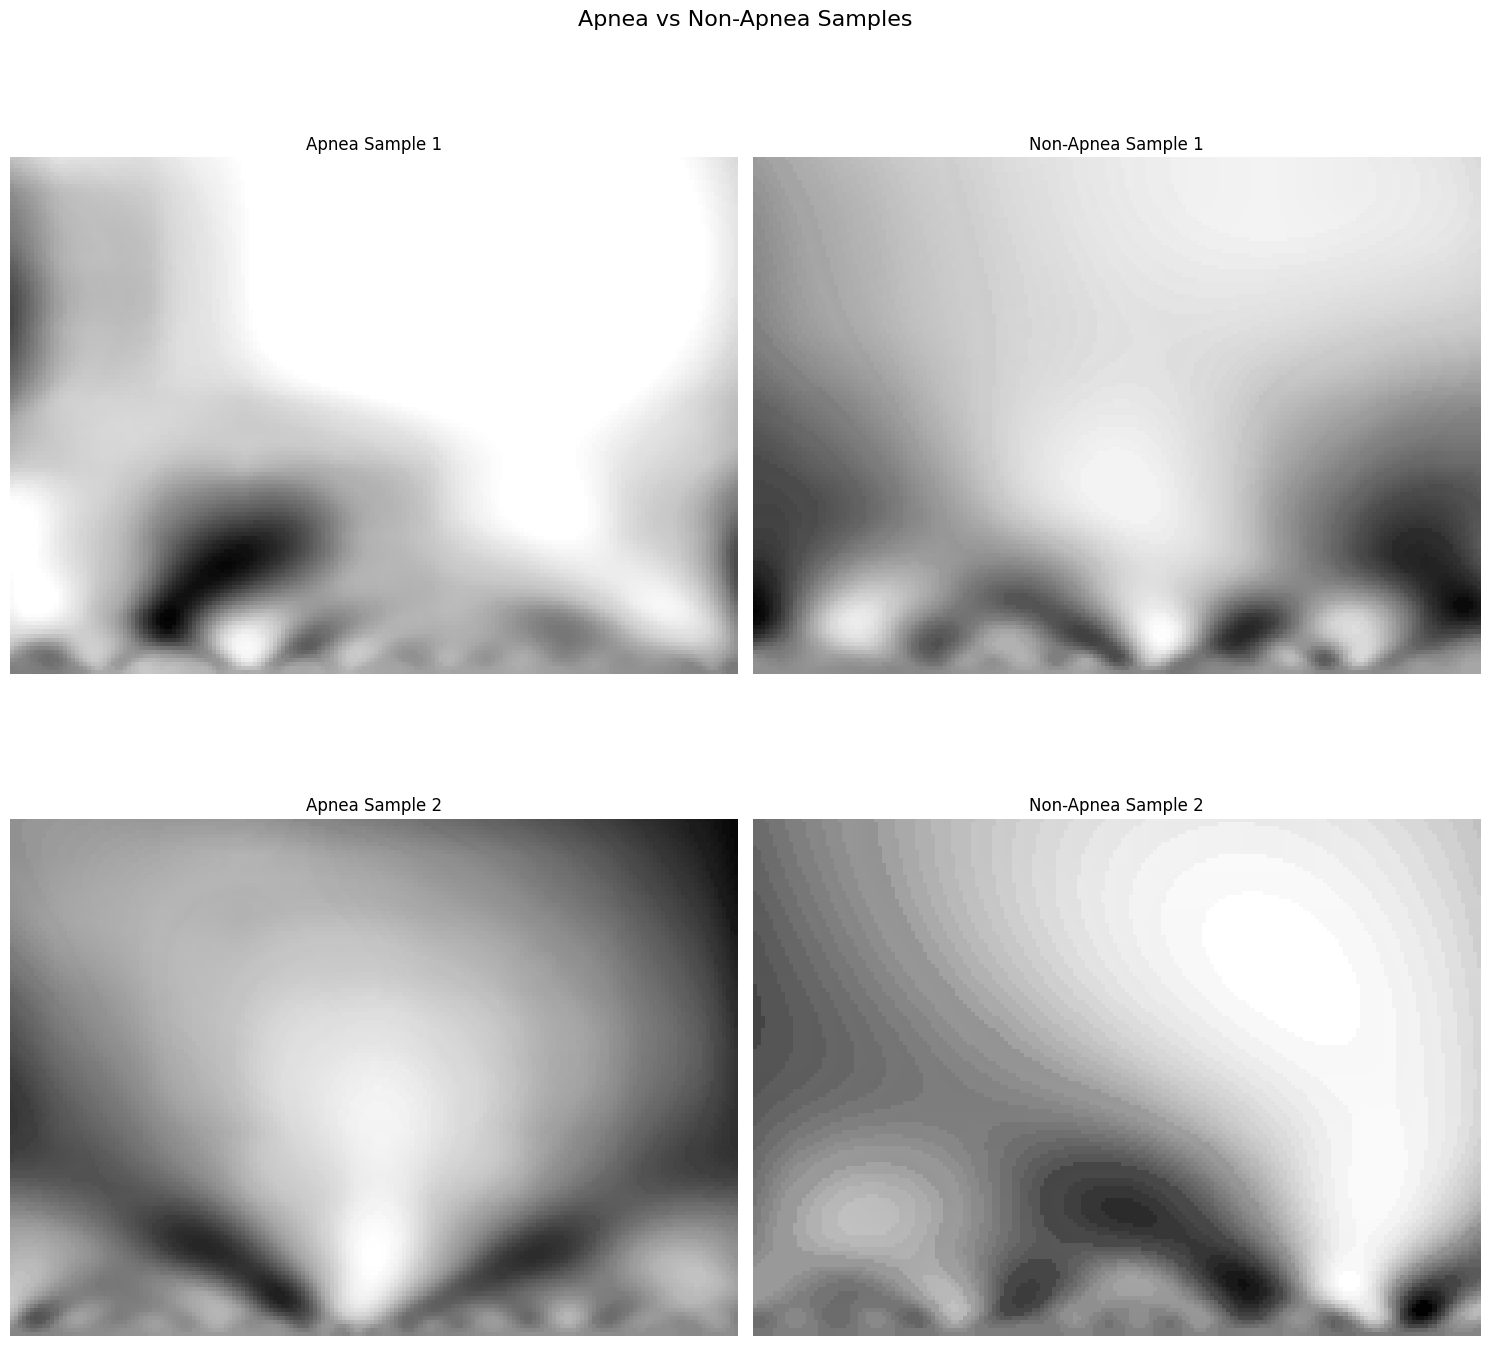

In [3]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def display_samples(base_dir, num_samples=2):
    apnea_dir = os.path.join(base_dir, "apnea")
    non_apnea_dir = os.path.join(base_dir, "non_apnea")

    # Get random samples
    apnea_samples = random.sample([f for f in os.listdir(apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))], num_samples)
    non_apnea_samples = random.sample([f for f in os.listdir(non_apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))], num_samples)

    # Set up the plot
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("Apnea vs Non-Apnea Samples", fontsize=16)

    # Display apnea samples
    for i, sample in enumerate(apnea_samples):
        img = cv2.imread(os.path.join(apnea_dir, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"Apnea Sample {i+1}")
        axs[i, 0].axis('off')

    # Display non-apnea samples
    for i, sample in enumerate(non_apnea_samples):
        img = cv2.imread(os.path.join(non_apnea_dir, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, 1].imshow(img)
        axs[i, 1].set_title(f"Non-Apnea Sample {i+1}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print the filenames
    print("Apnea Samples:")
    for sample in apnea_samples:
        print(f"- {sample}")
    print("\nNon-Apnea Samples:")
    for sample in non_apnea_samples:
        print(f"- {sample}")

# Replace this with the path to your dataset folder
base_dir = "/content/Binary_Classification_Apnea"
display_samples(base_dir)

In [4]:
!pip install split-folders

Apnea Samples:
- 8698.png
- 11804.png

Non-Apnea Samples:
- 23338.png
- 4999.png


In [5]:
import splitfolders

# Path to your dataset
# input_folder = '/content/Mosquito_Dataset_CNN'
input_folder = '/content/Binary_Classification_Apnea'

# Output folder
output_folder = '/content/Dataset'

# Split the dataset (train: 80%, val: 10%, test: 10%)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1))

Copying files: 13998 files [00:02, 6540.13 files/s]


importing the required libraries

In [6]:
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, BatchNormalization, Dropout, Flatten, Reshape
from tensorflow.keras.optimizers import Adam


In [7]:
train_path = '/content/Dataset/train'
val_path = '/content/Dataset/val'
test_path = '/content/Dataset/test'
# Get the number of files and classes
train_image_files = glob.glob(train_path + '/*/*.png')
val_image_files = glob.glob(val_path + '/*/*.png')
test_image_files = glob.glob(test_path + '/*/*.png')
num_train_images = len(train_image_files)
num_val_images = len(val_image_files)
num_test_images = len(test_image_files)
folders = glob.glob(train_path + '/*')
num_classes = len(folders)

# Parameters
img_height, img_width = 128, 180  # Resizing the images
batch_size = 256
epochs = 100
# Image data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 11198 images belonging to 2 classes.
Found 1398 images belonging to 2 classes.
Found 1402 images belonging to 2 classes.


In [10]:
from tensorflow.keras.models import load_model


model = load_model('/content/Main_model.keras')
evaluation = model.evaluate(train_generator)
evaluation = model.evaluate(val_generator)
evaluation = model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.9953 - loss: 0.0160
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 738ms/step - accuracy: 0.9958 - loss: 0.0128
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 736ms/step - accuracy: 0.9937 - loss: 0.0112


# XAI Part

In [16]:
!pip install xplique

In [19]:

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from math import ceil
import cv2

%matplotlib inline
%config InlineBackend.figure_format='retina'

import xplique
from xplique.plots import plot_attributions

Initial Preprocessing

# Using GRADCam

Found 1402 images belonging to 2 classes.


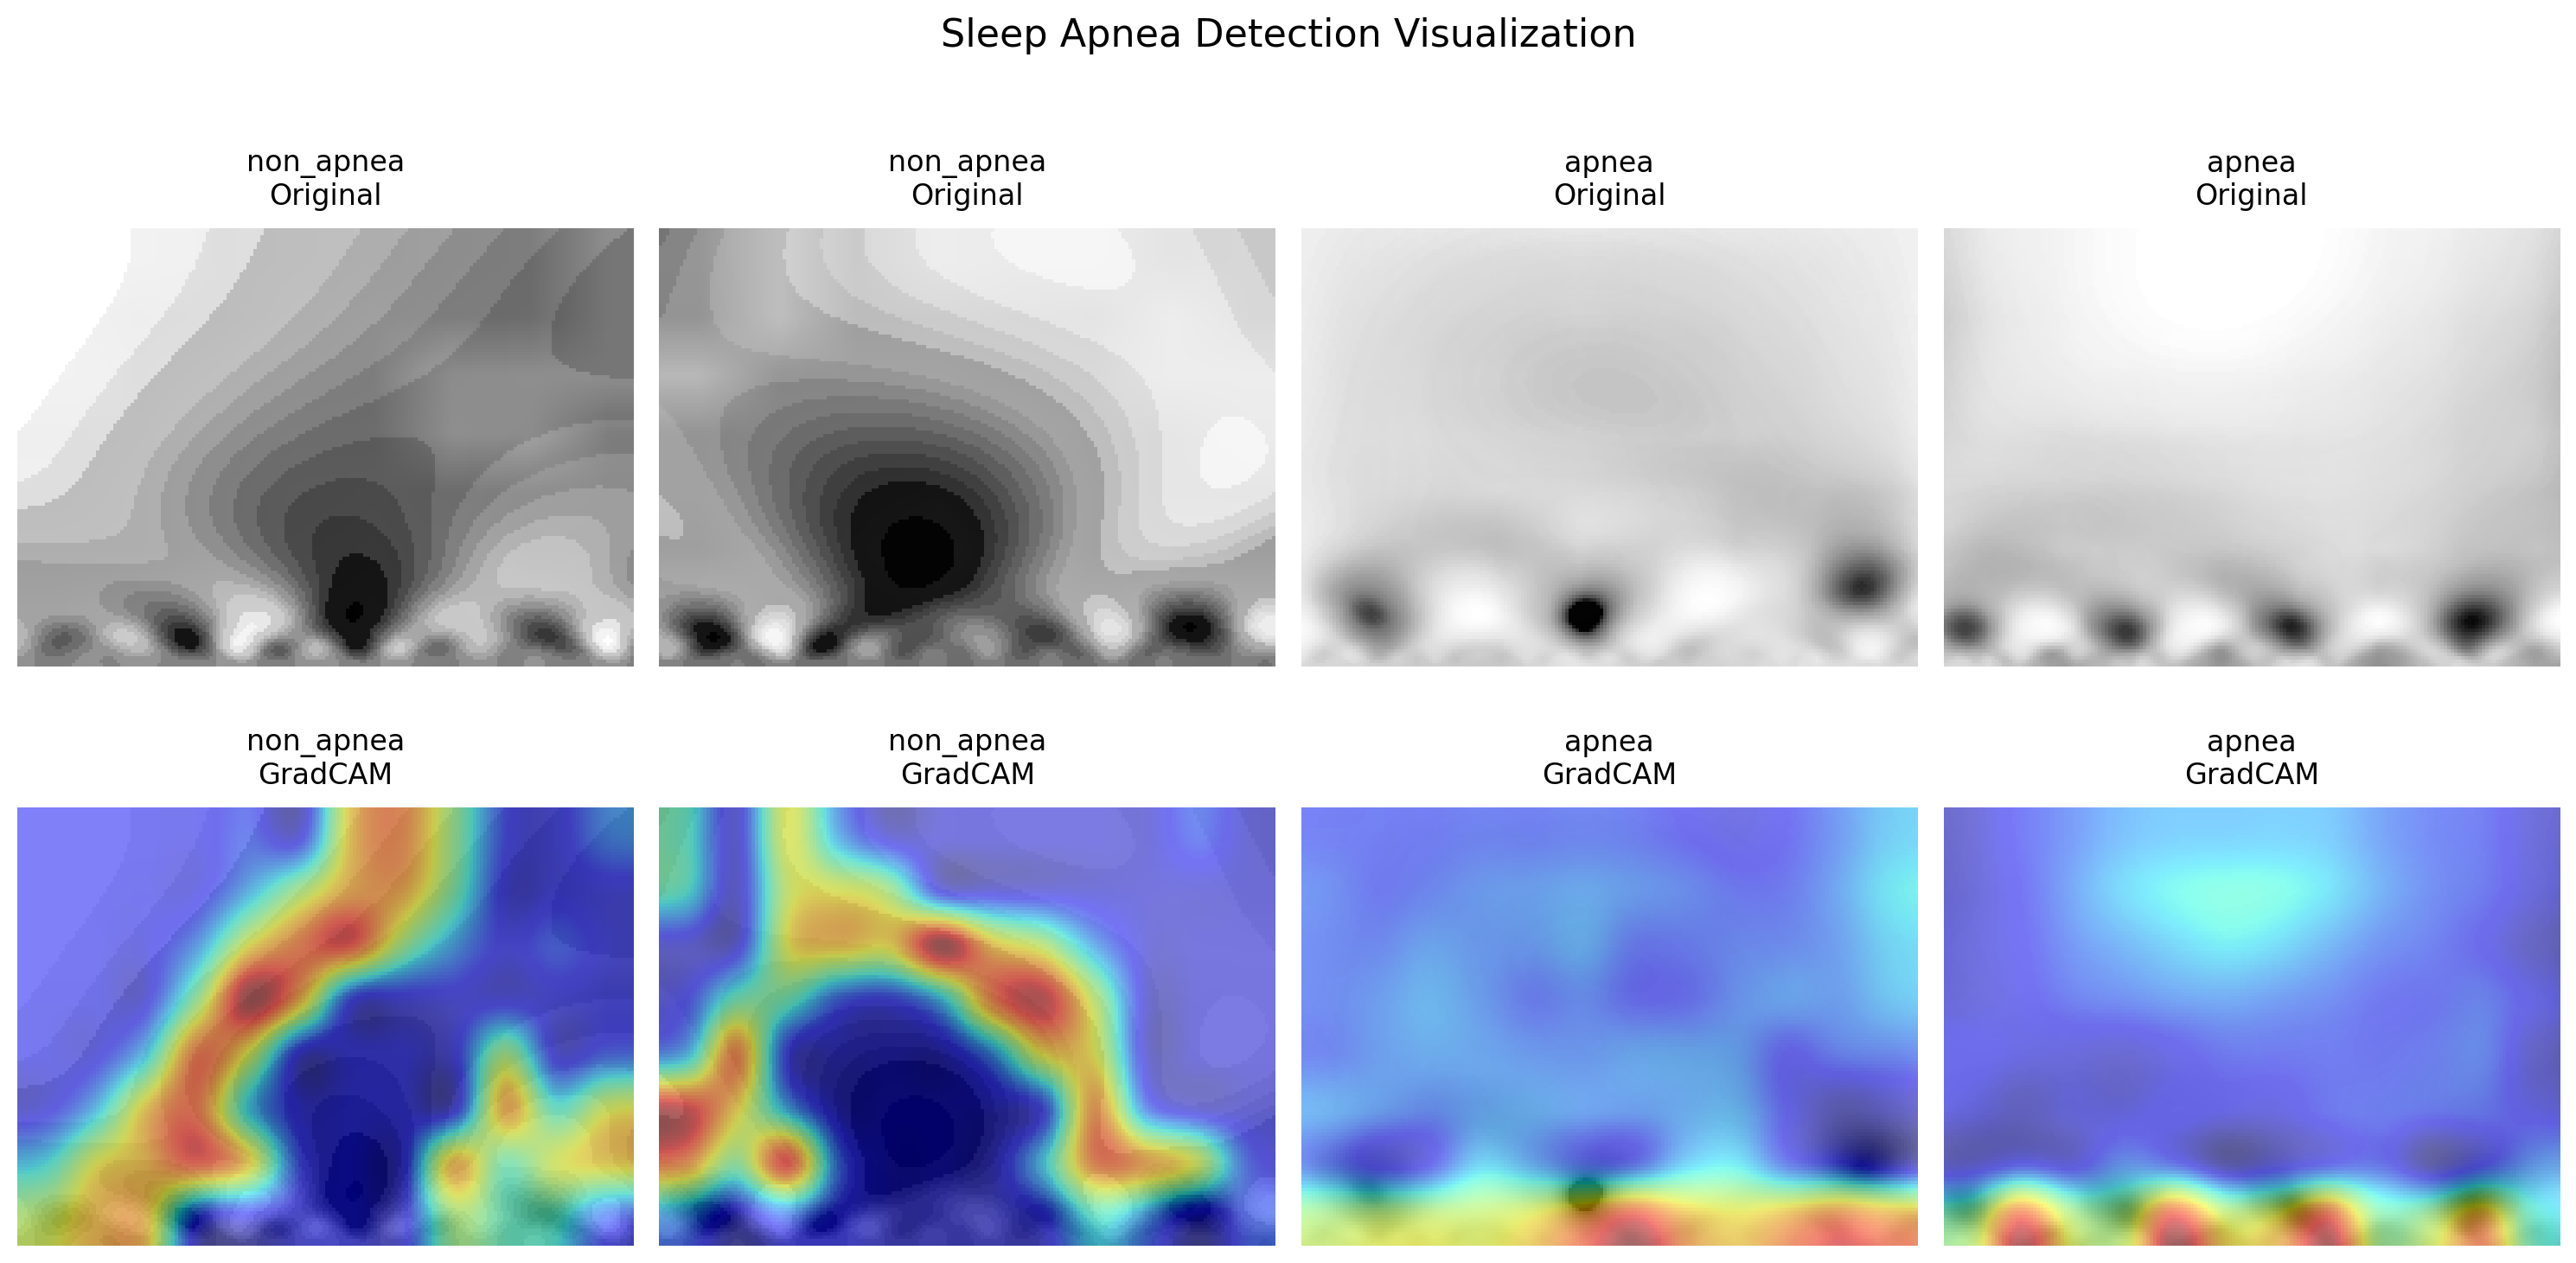


Image 1 (non_apnea)
Confidence: 100.00%

Image 2 (non_apnea)
Confidence: 100.00%

Image 3 (apnea)
Confidence: 100.00%

Image 4 (apnea)
Confidence: 100.00%


In [27]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from xplique.attributions import GradCAM

# Set parameters
img_height = 128
img_width = 180
n_samples_per_class = 2
classes = ['apnea', 'non_apnea']

# Create data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Function to get specific number of samples per class
def get_balanced_samples(generator, n_samples_per_class):
    images = []
    labels = []
    samples_count = {0: 0, 1: 0}

    generator.reset()
    while min(samples_count.values()) < n_samples_per_class:
        X_batch, y_batch = next(generator)
        class_idx = np.argmax(y_batch[0])

        if samples_count[class_idx] < n_samples_per_class:
            images.append(X_batch[0])
            labels.append(y_batch[0])
            samples_count[class_idx] += 1

    return np.array(images), np.array(labels)

# Setup generator
test_generator = test_datagen.flow_from_directory(
    'Dataset/test',
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)

# Get balanced samples
X_samples, y_samples = get_balanced_samples(test_generator, n_samples_per_class)

# Convert grayscale to 3 channels for visualization
X_display = np.repeat(X_samples, 3, axis=-1)

# Load the model
model = tf.keras.models.load_model('/content/Main_model.keras')

# Create the GradCAM explainer
explainer = GradCAM(model)

# Generate explanations
explanations = explainer(X_samples, y_samples)

# Create a nice figure with original images and GradCAM
plt.figure(figsize=(15, 8))

# Add title to the entire figure
plt.suptitle('Sleep Apnea Detection Visualization', fontsize=16, y=0.98)

for i, (image, explanation) in enumerate(zip(X_display, explanations)):
    # Original image
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f'{classes[np.argmax(y_samples[i])]}\nOriginal', pad=10)
    plt.axis('off')

    # GradCAM visualization
    plt.subplot(2, 4, i + 5)
    plt.imshow(image)
    plt.imshow(explanation, cmap="jet", alpha=0.5)
    plt.title(f'{classes[np.argmax(y_samples[i])]}\nGradCAM', pad=10)
    plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Save the figure with high DPI
plt.savefig('Sleep_Apnea_GradCAM_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print prediction confidence for each image
for i, image in enumerate(X_samples):
    prediction = model.predict(image[np.newaxis, ...], verbose=0)
    print(f"\nImage {i+1} ({classes[np.argmax(y_samples[i])]})")
    print(f"Confidence: {prediction[0][np.argmax(prediction[0])]:.2%}")

Selecting random images...
Selected 5568.png from class apnea
Selected 16445.png from class non_apnea


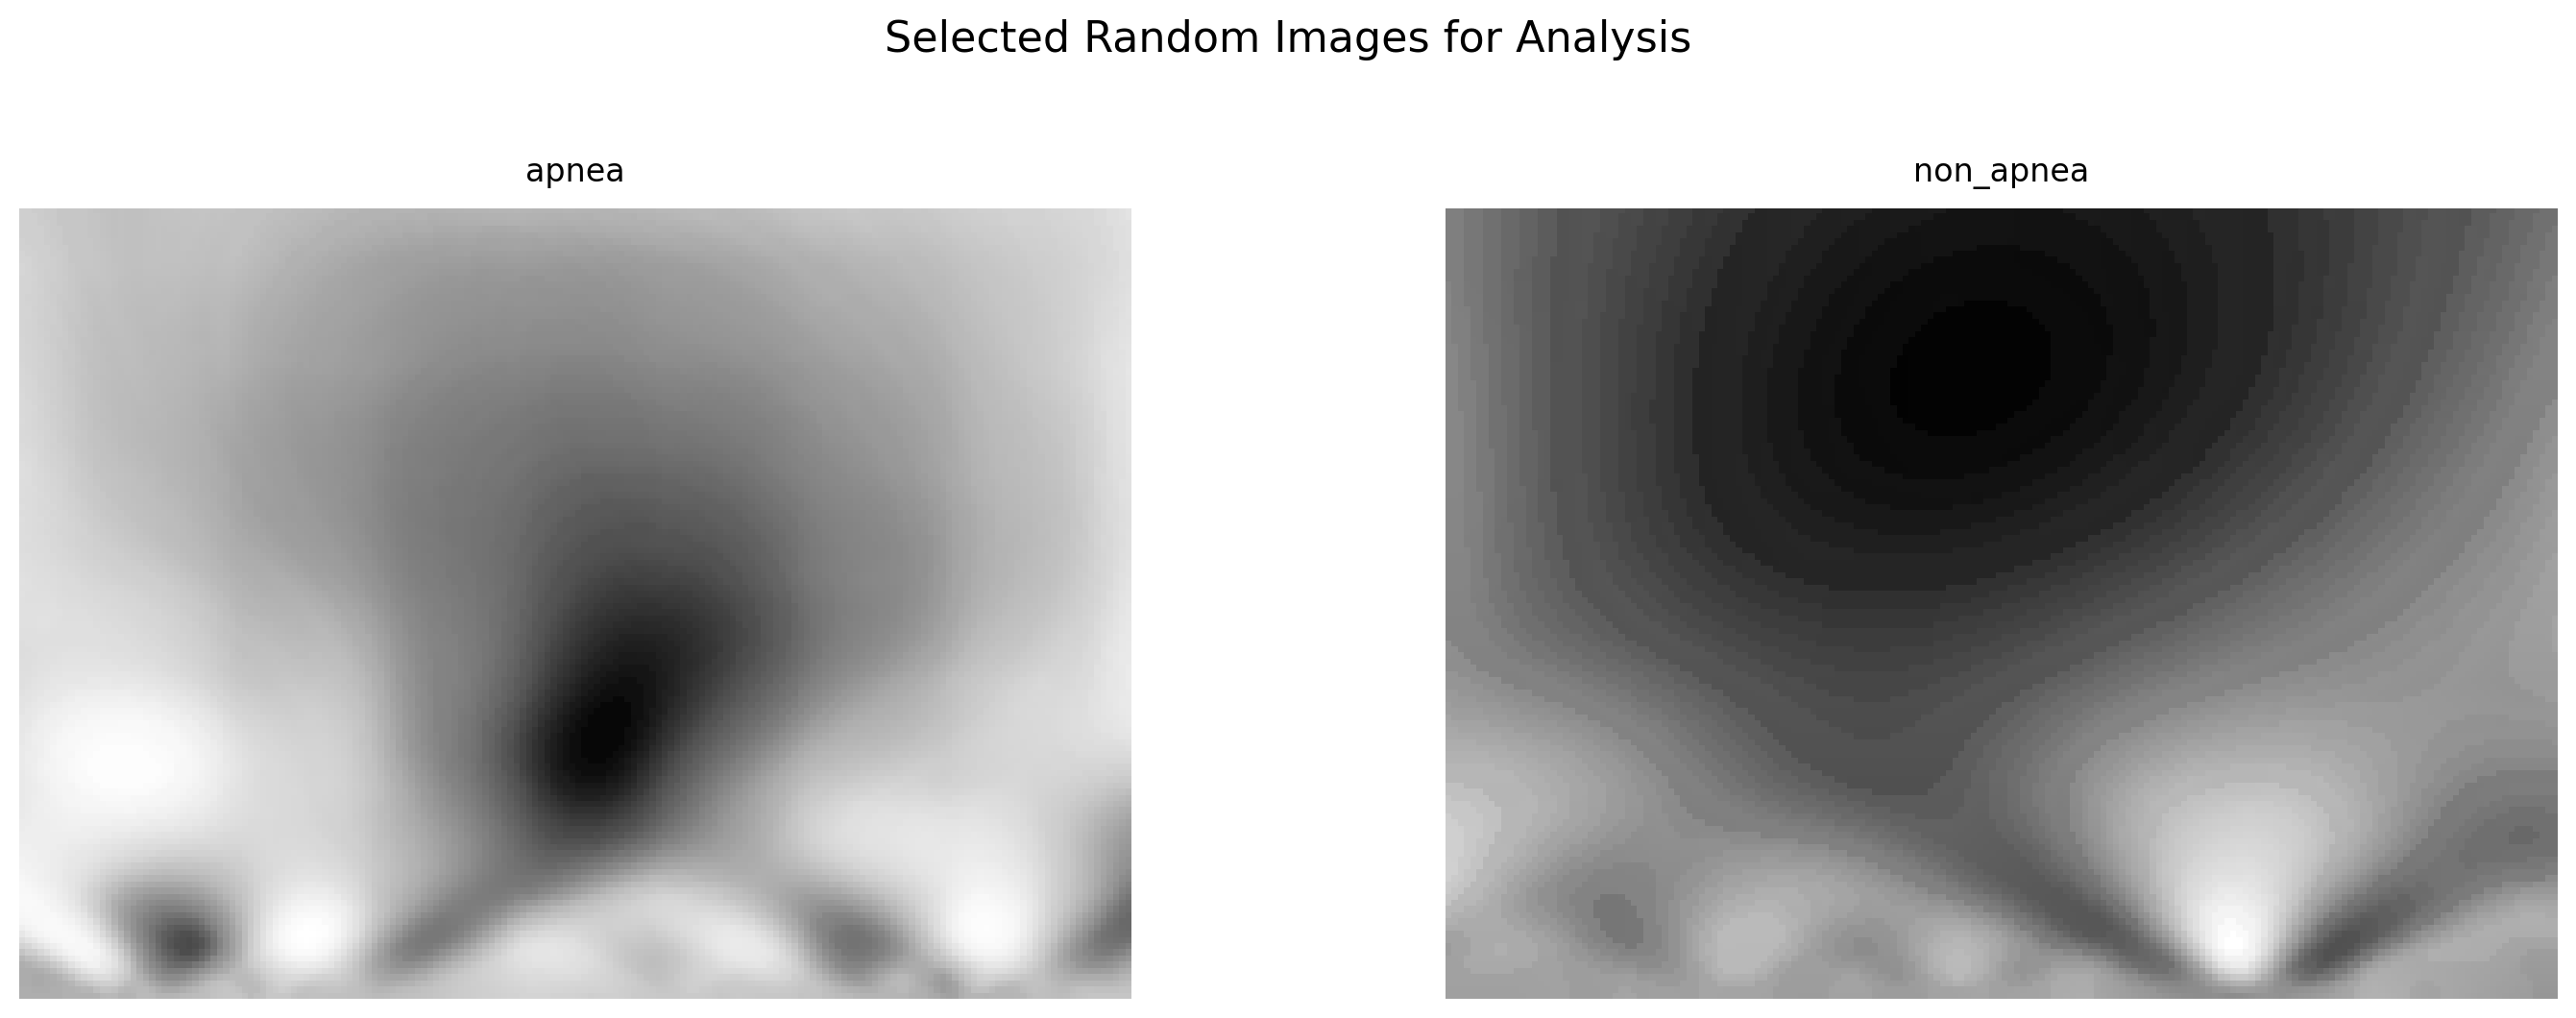


Predictions for selected images:
Image 1 (apnea)
Confidence: 100.00%

Image 2 (non_apnea)
Confidence: 100.00%


Generating Saliency explanations...


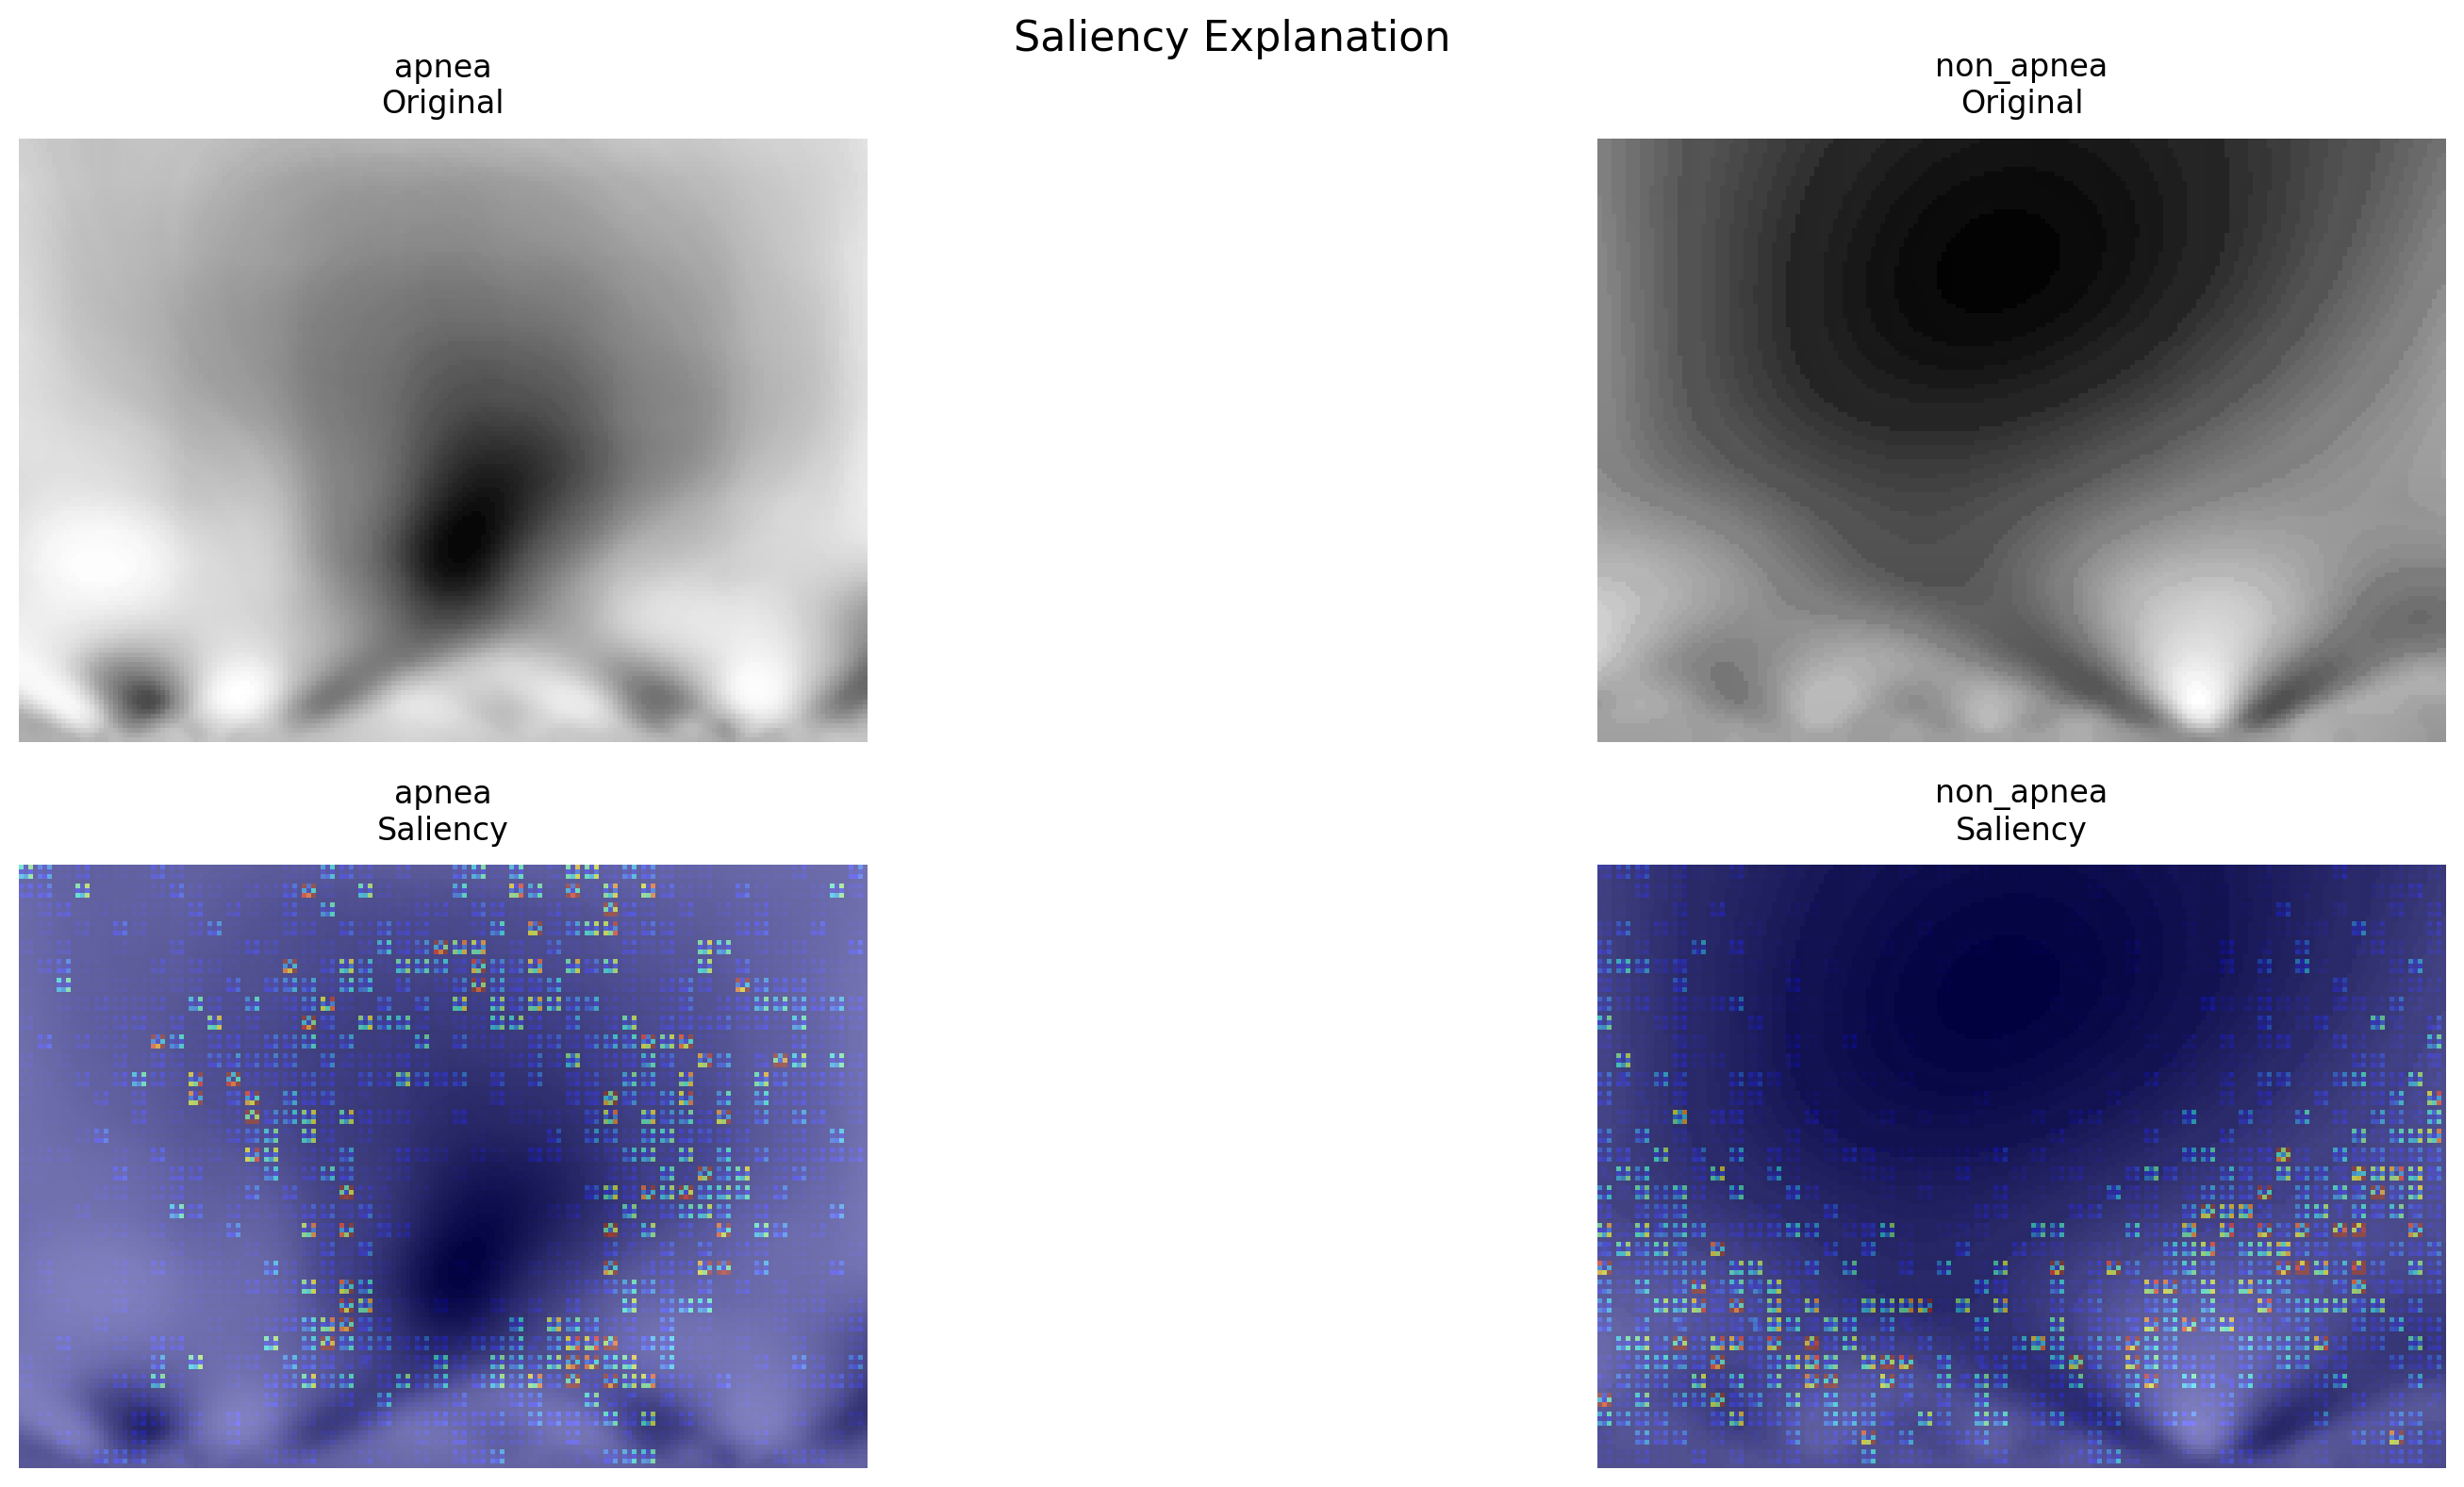


Generating GradientInput explanations...


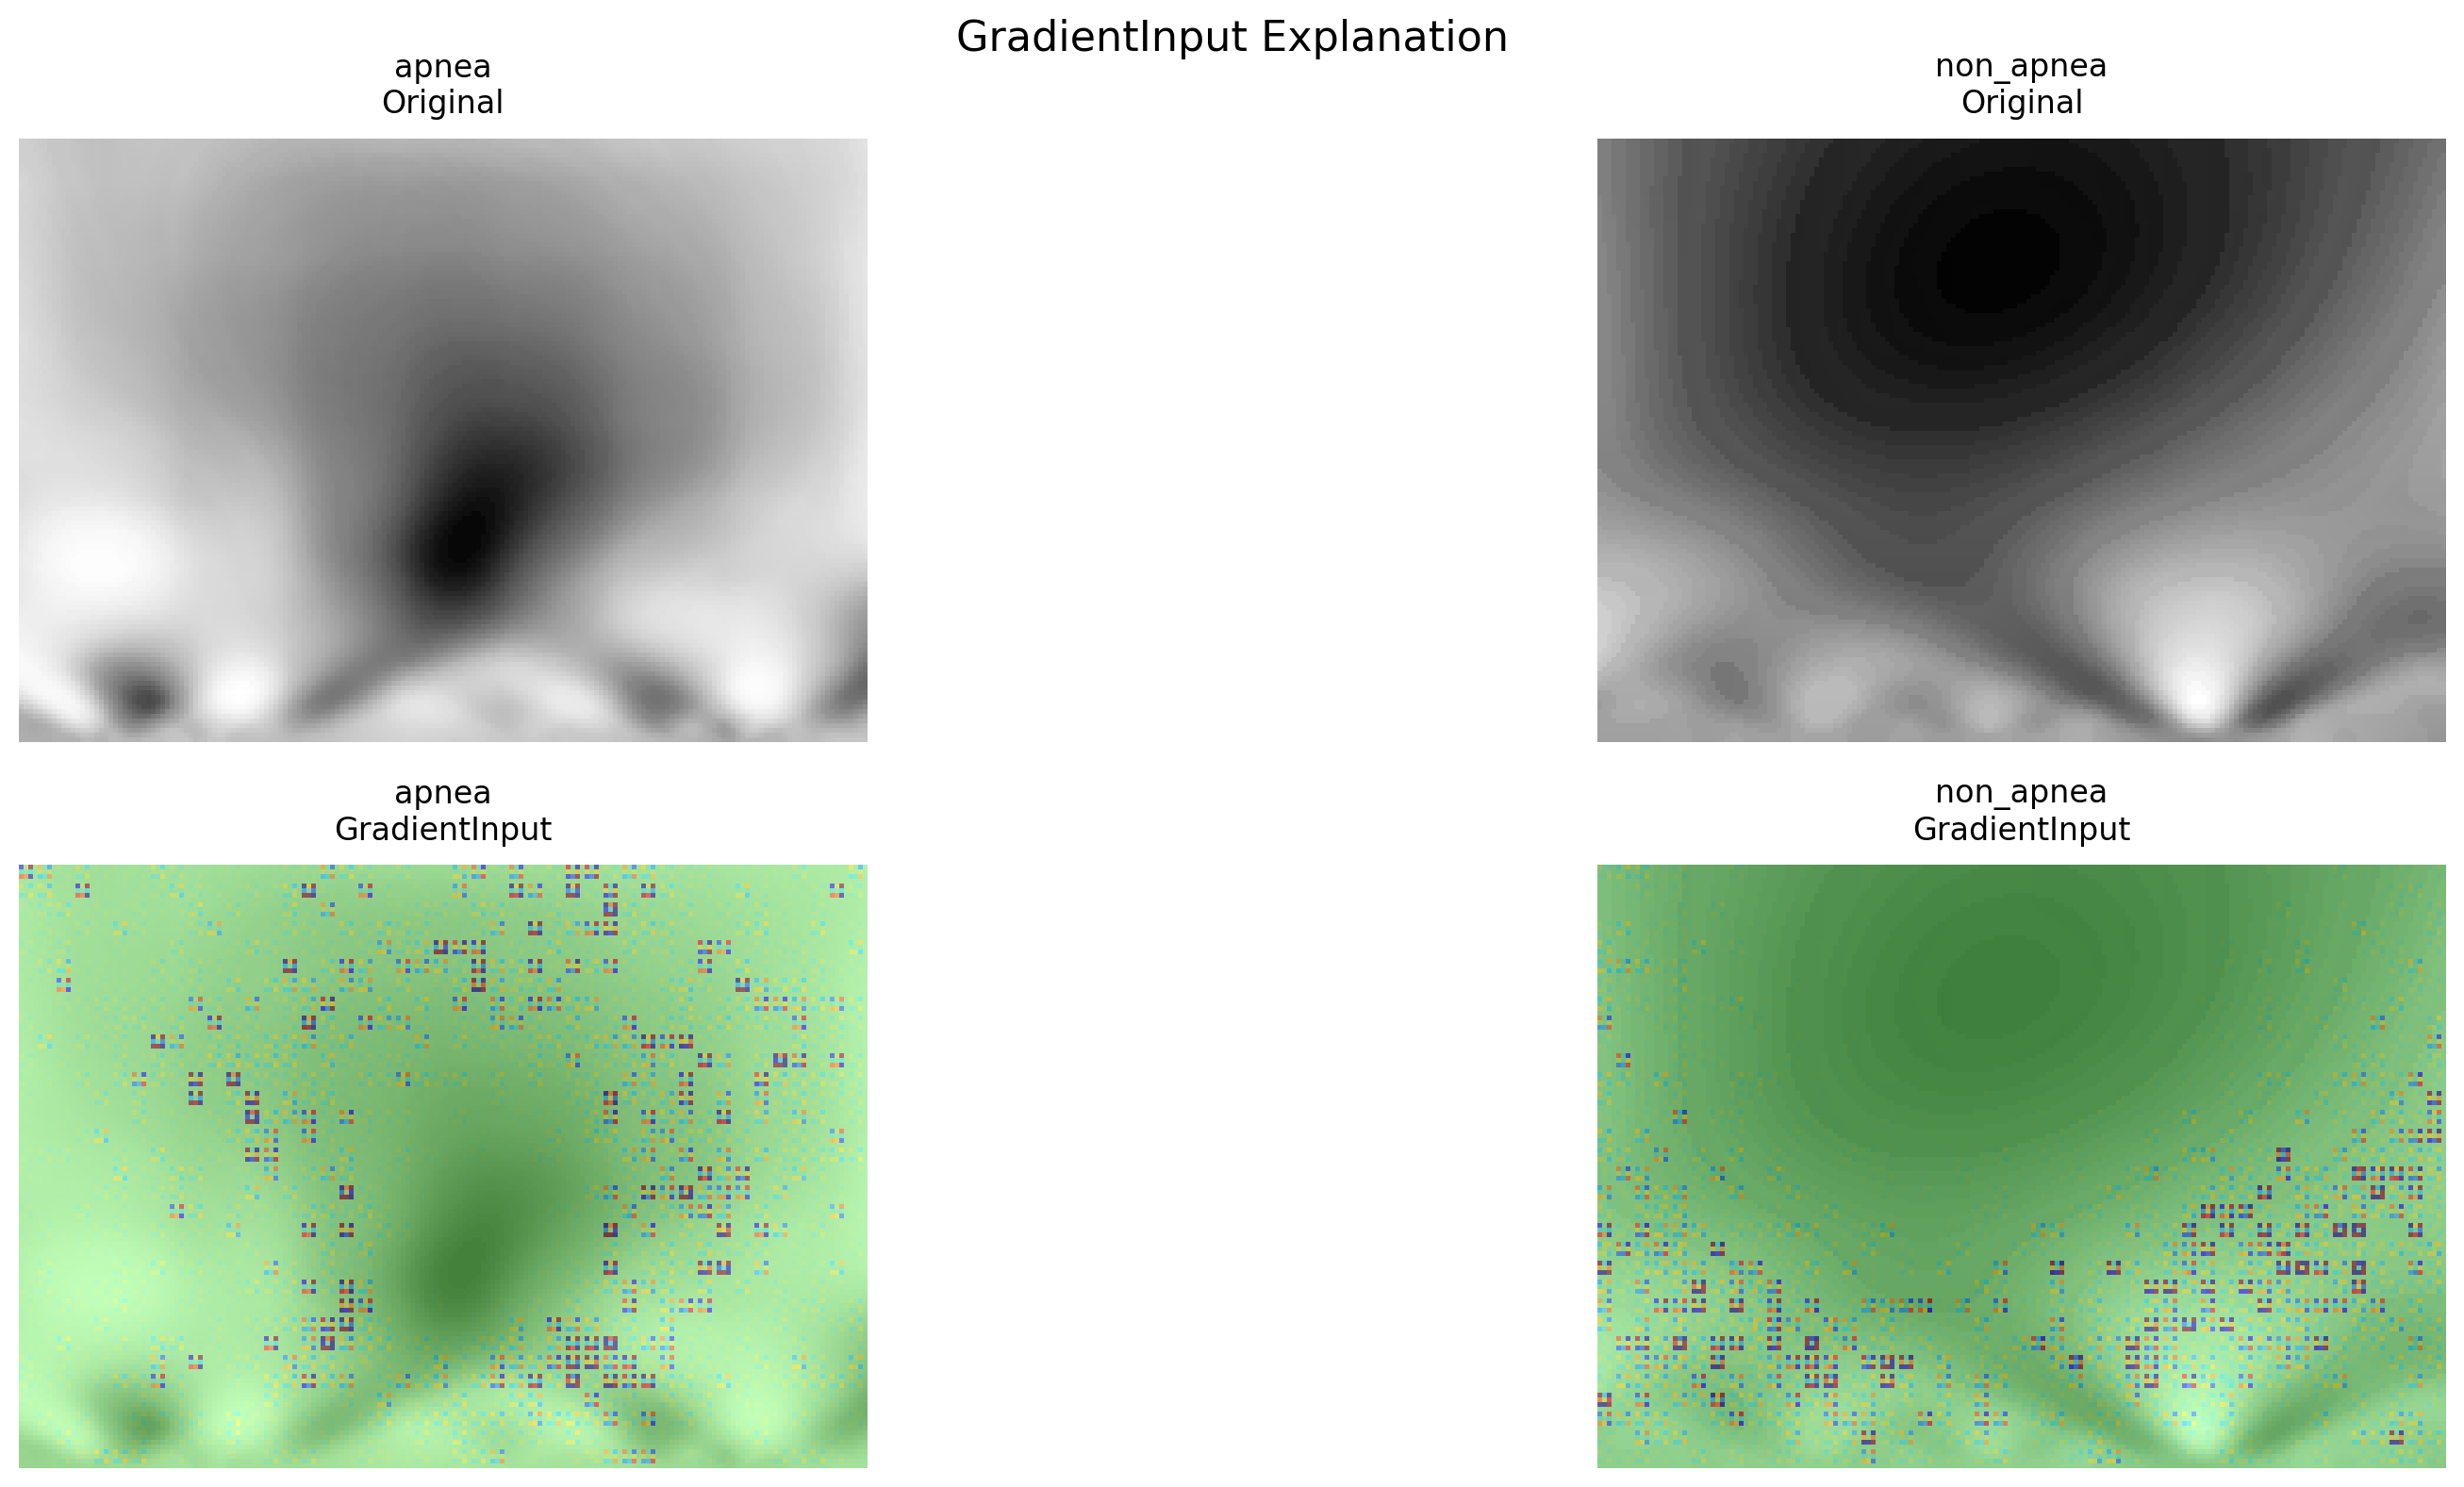


Generating GuidedBackprop explanations...


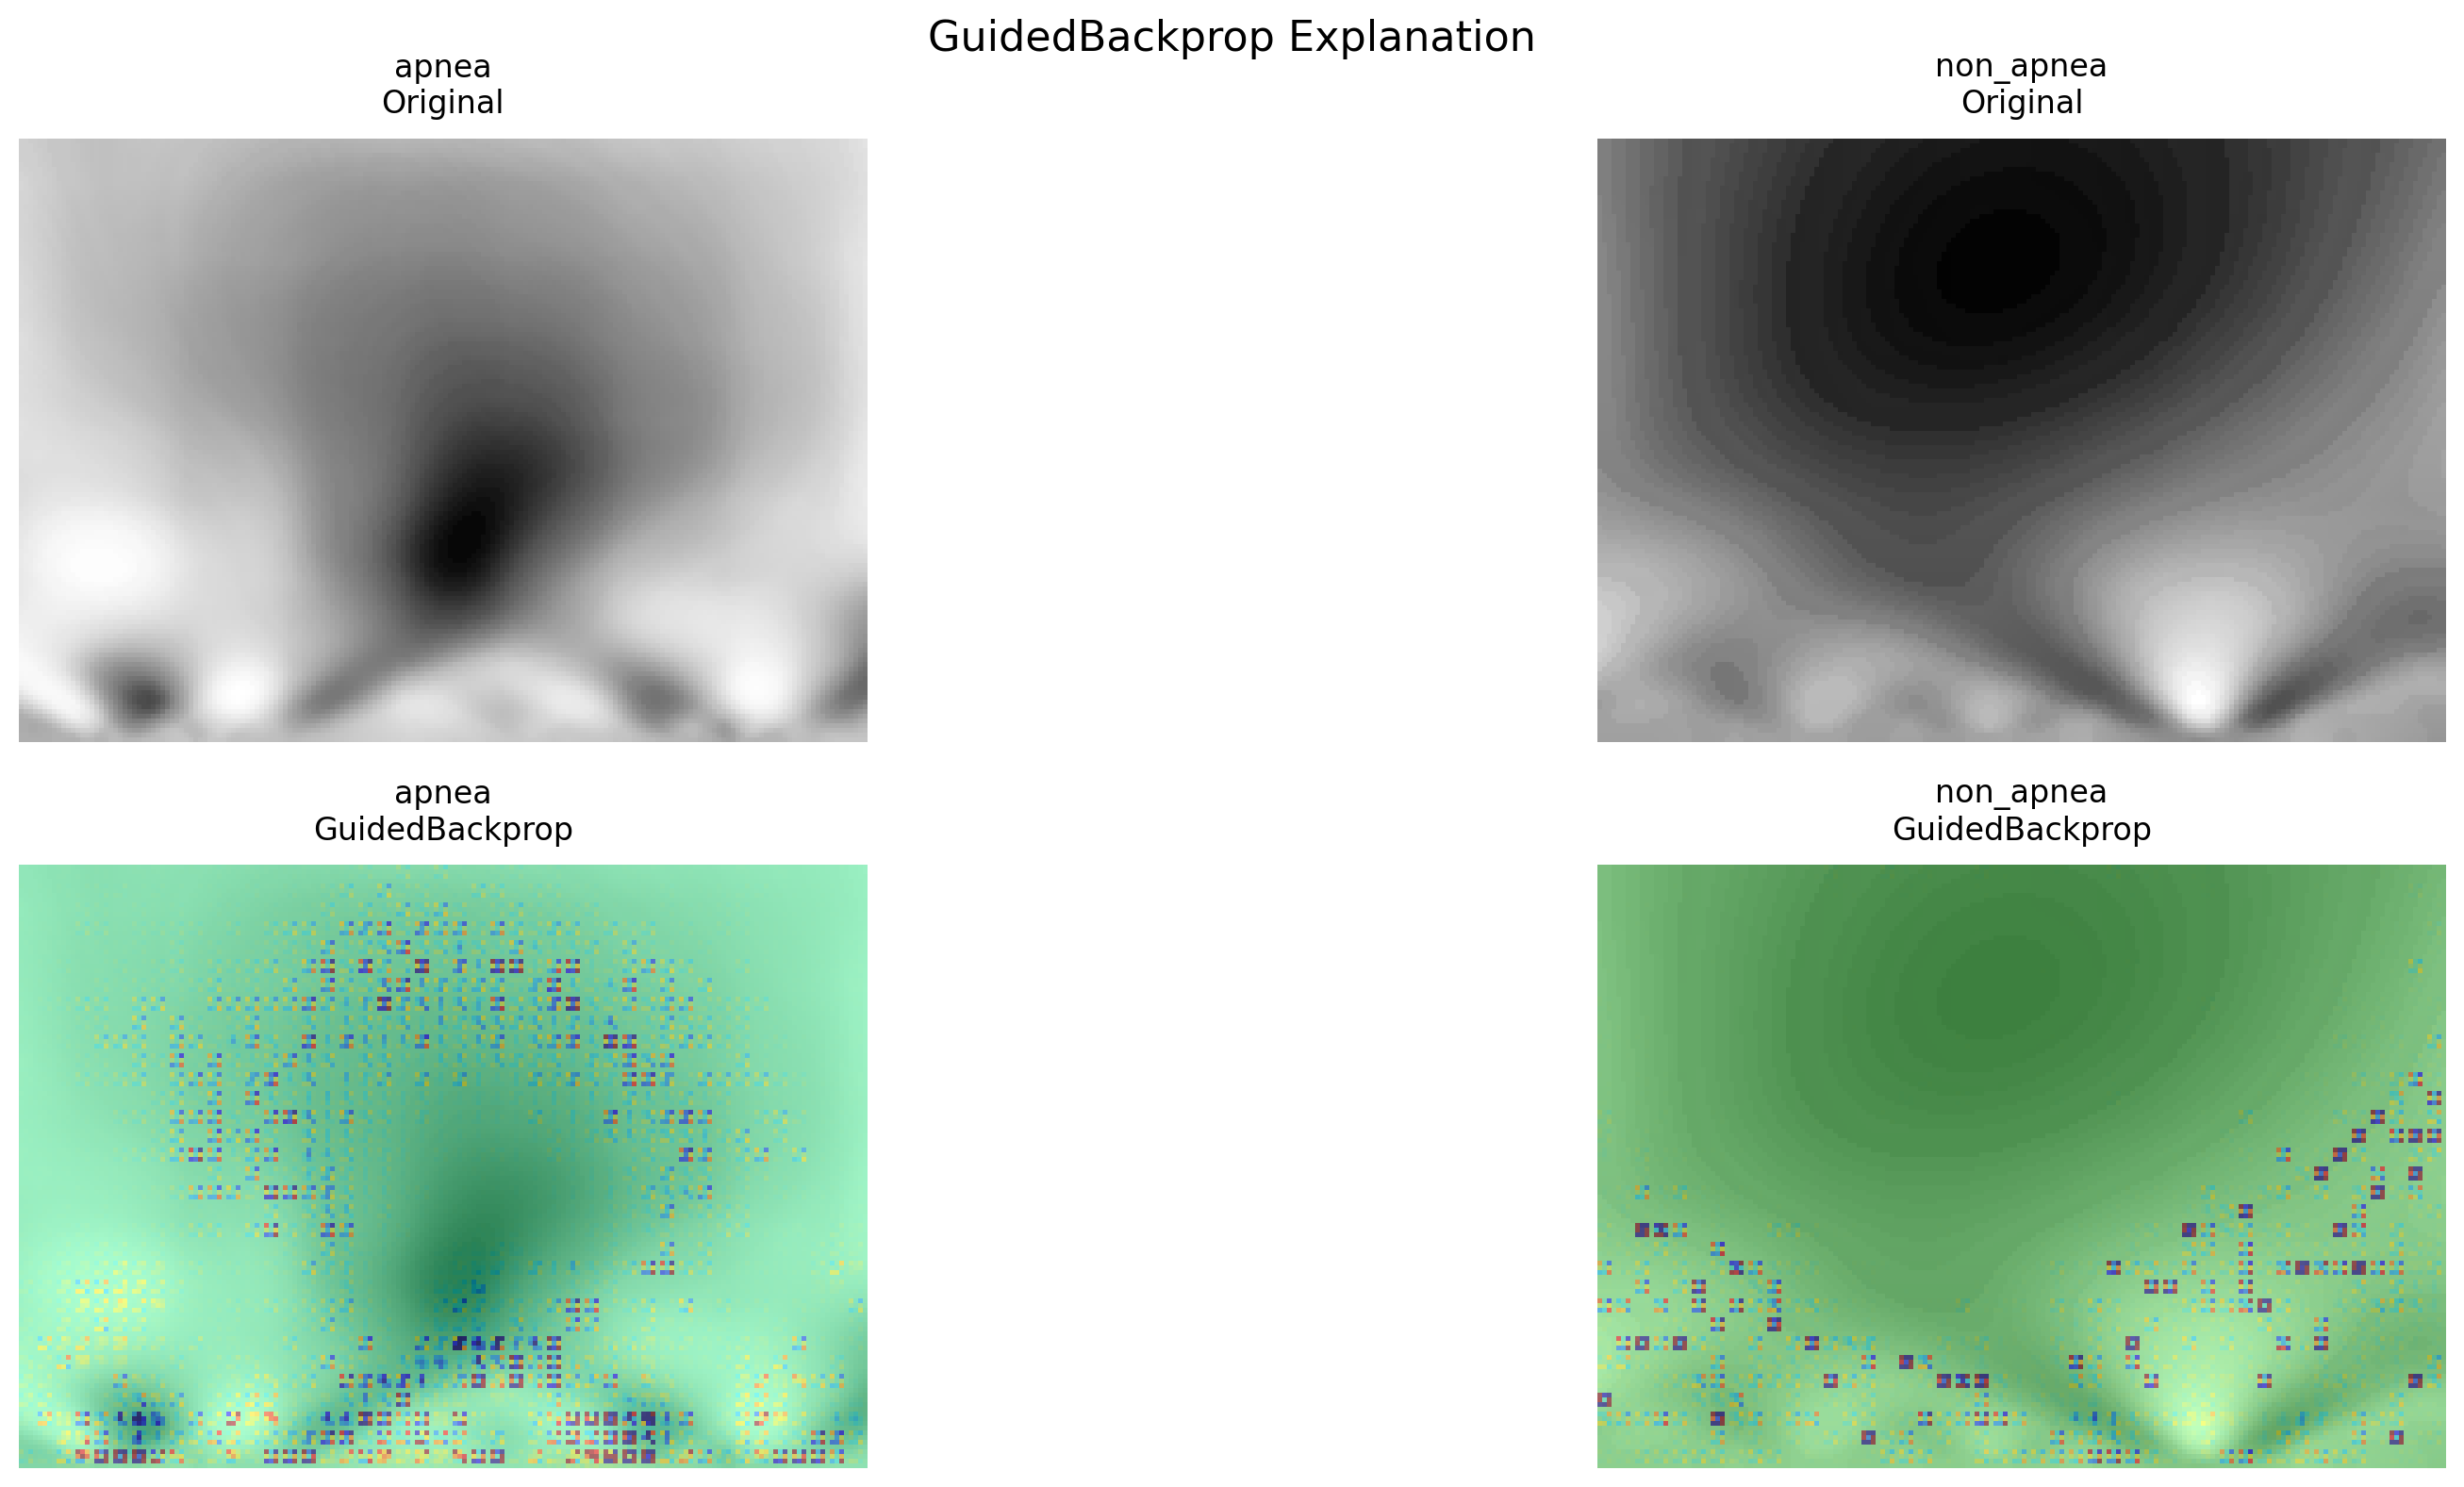


Generating IntegratedGradients explanations...


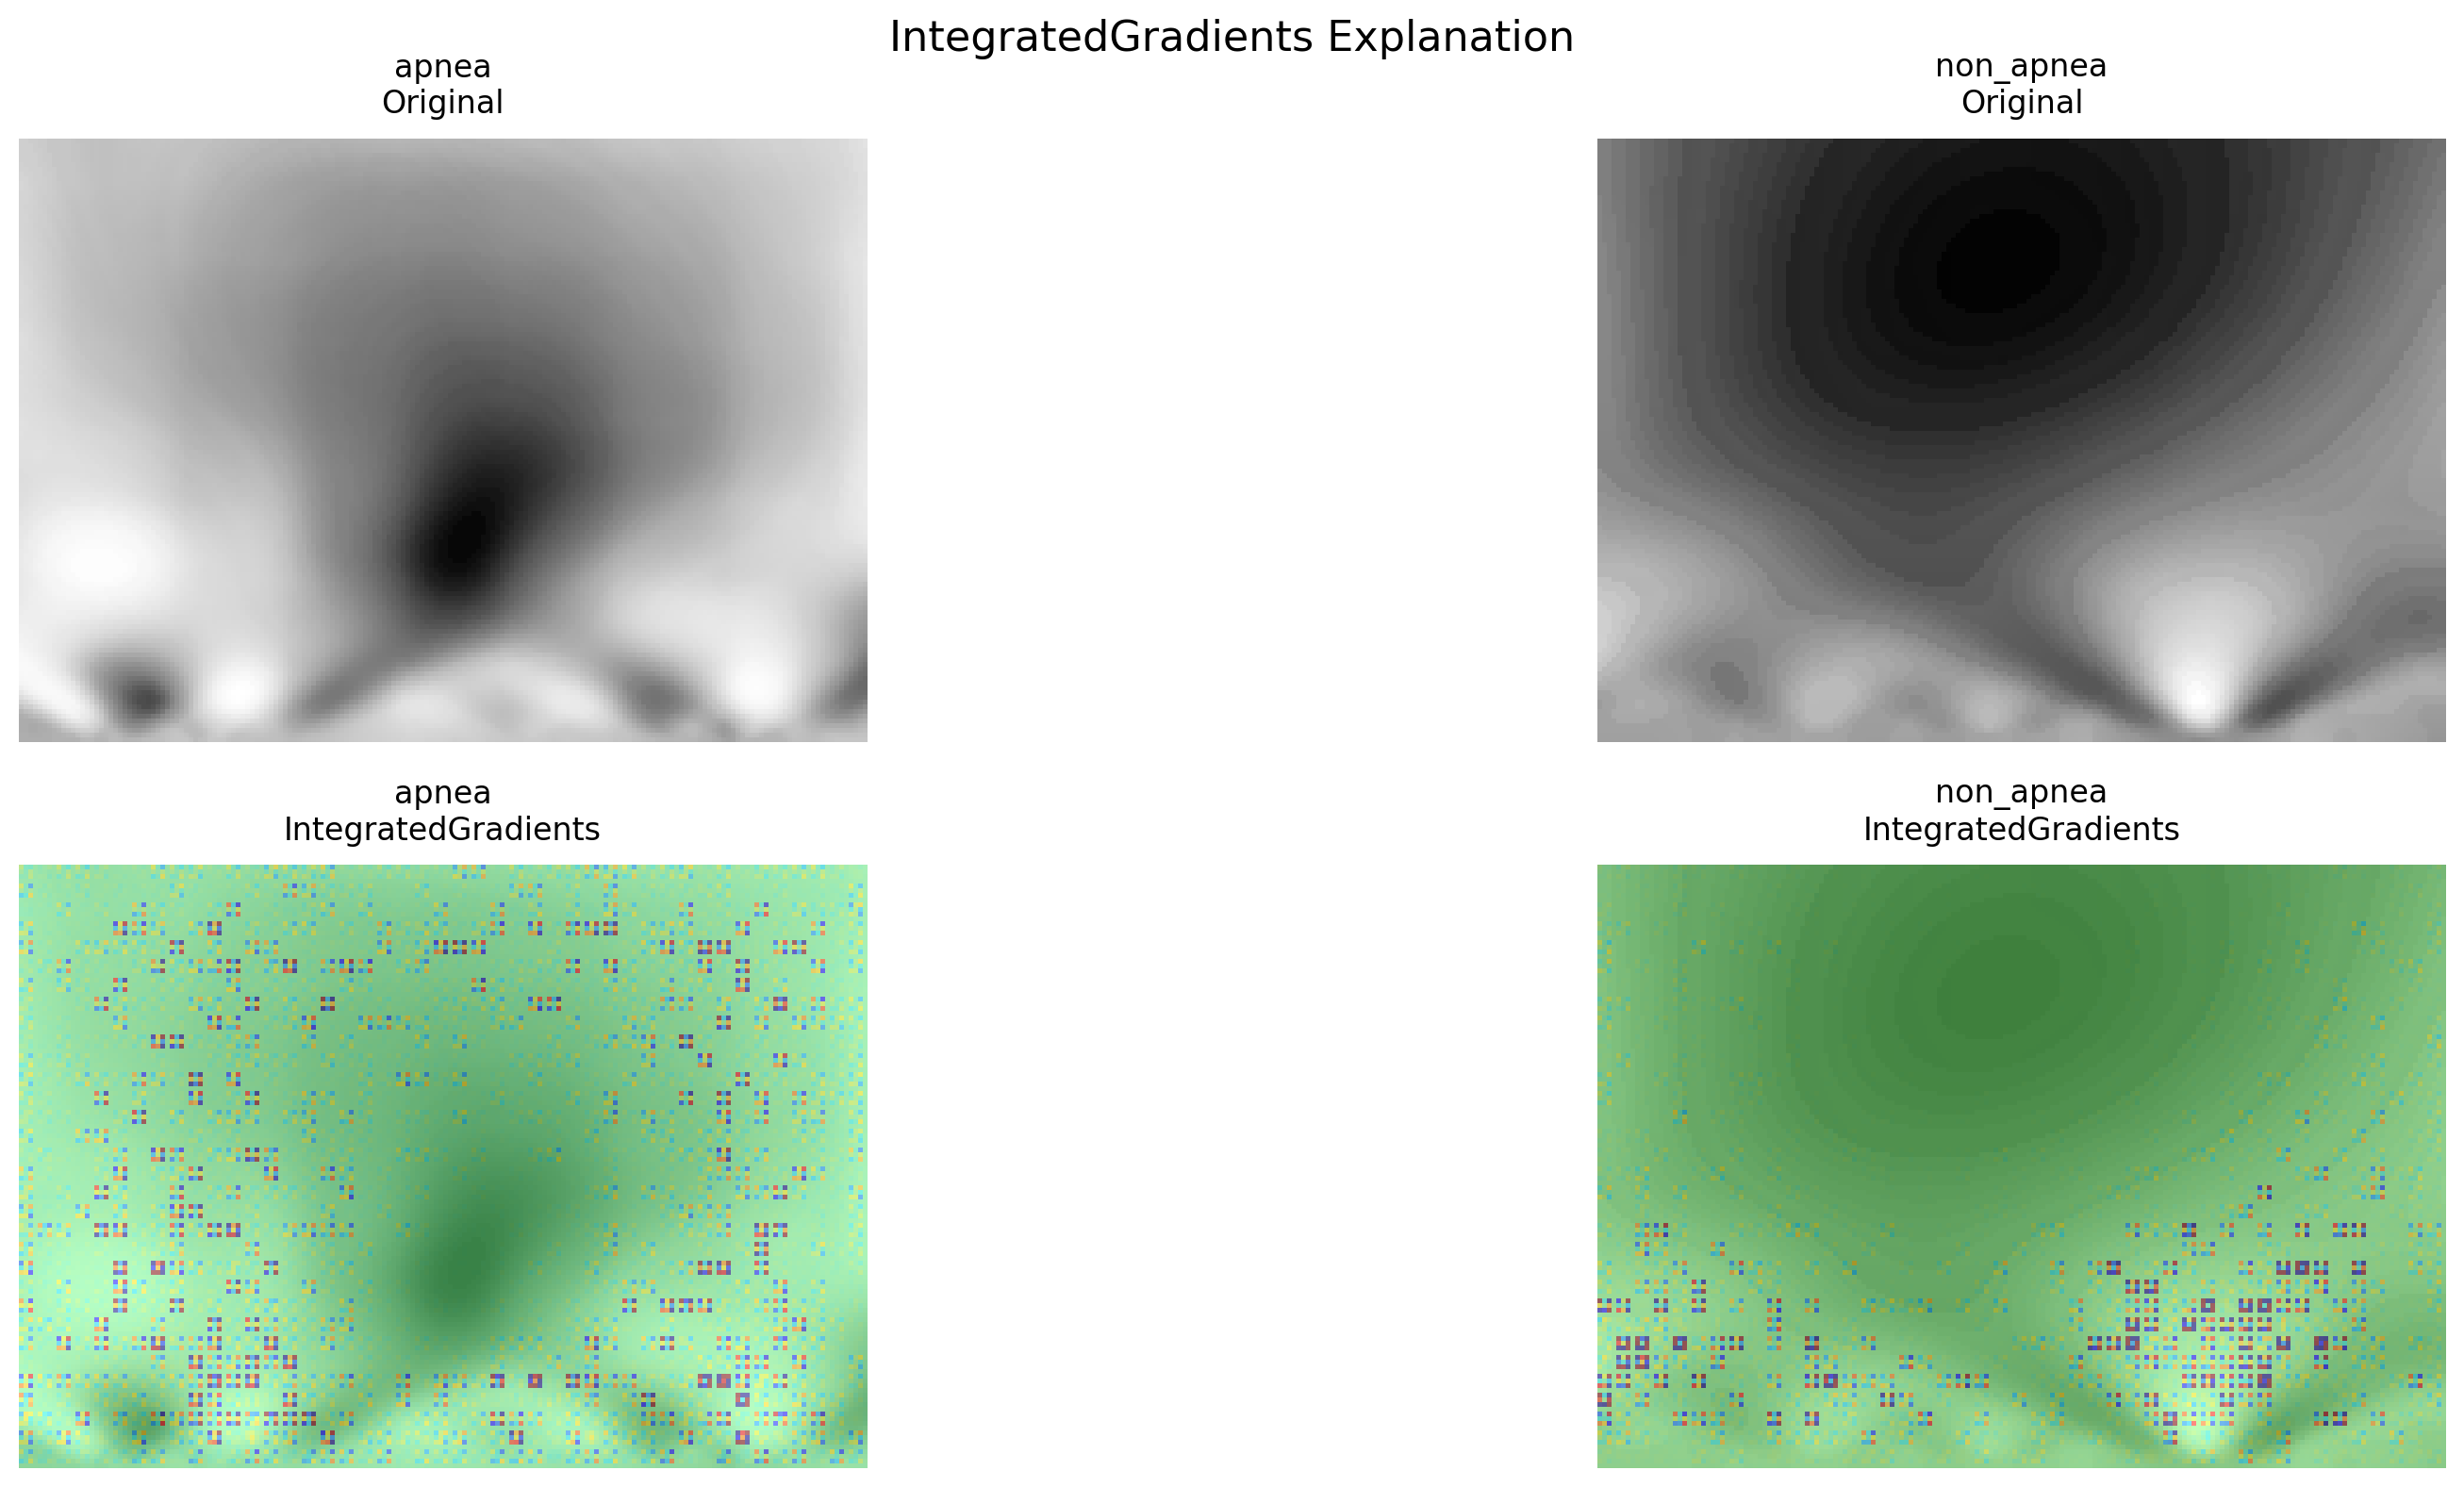


Generating SmoothGrad explanations...


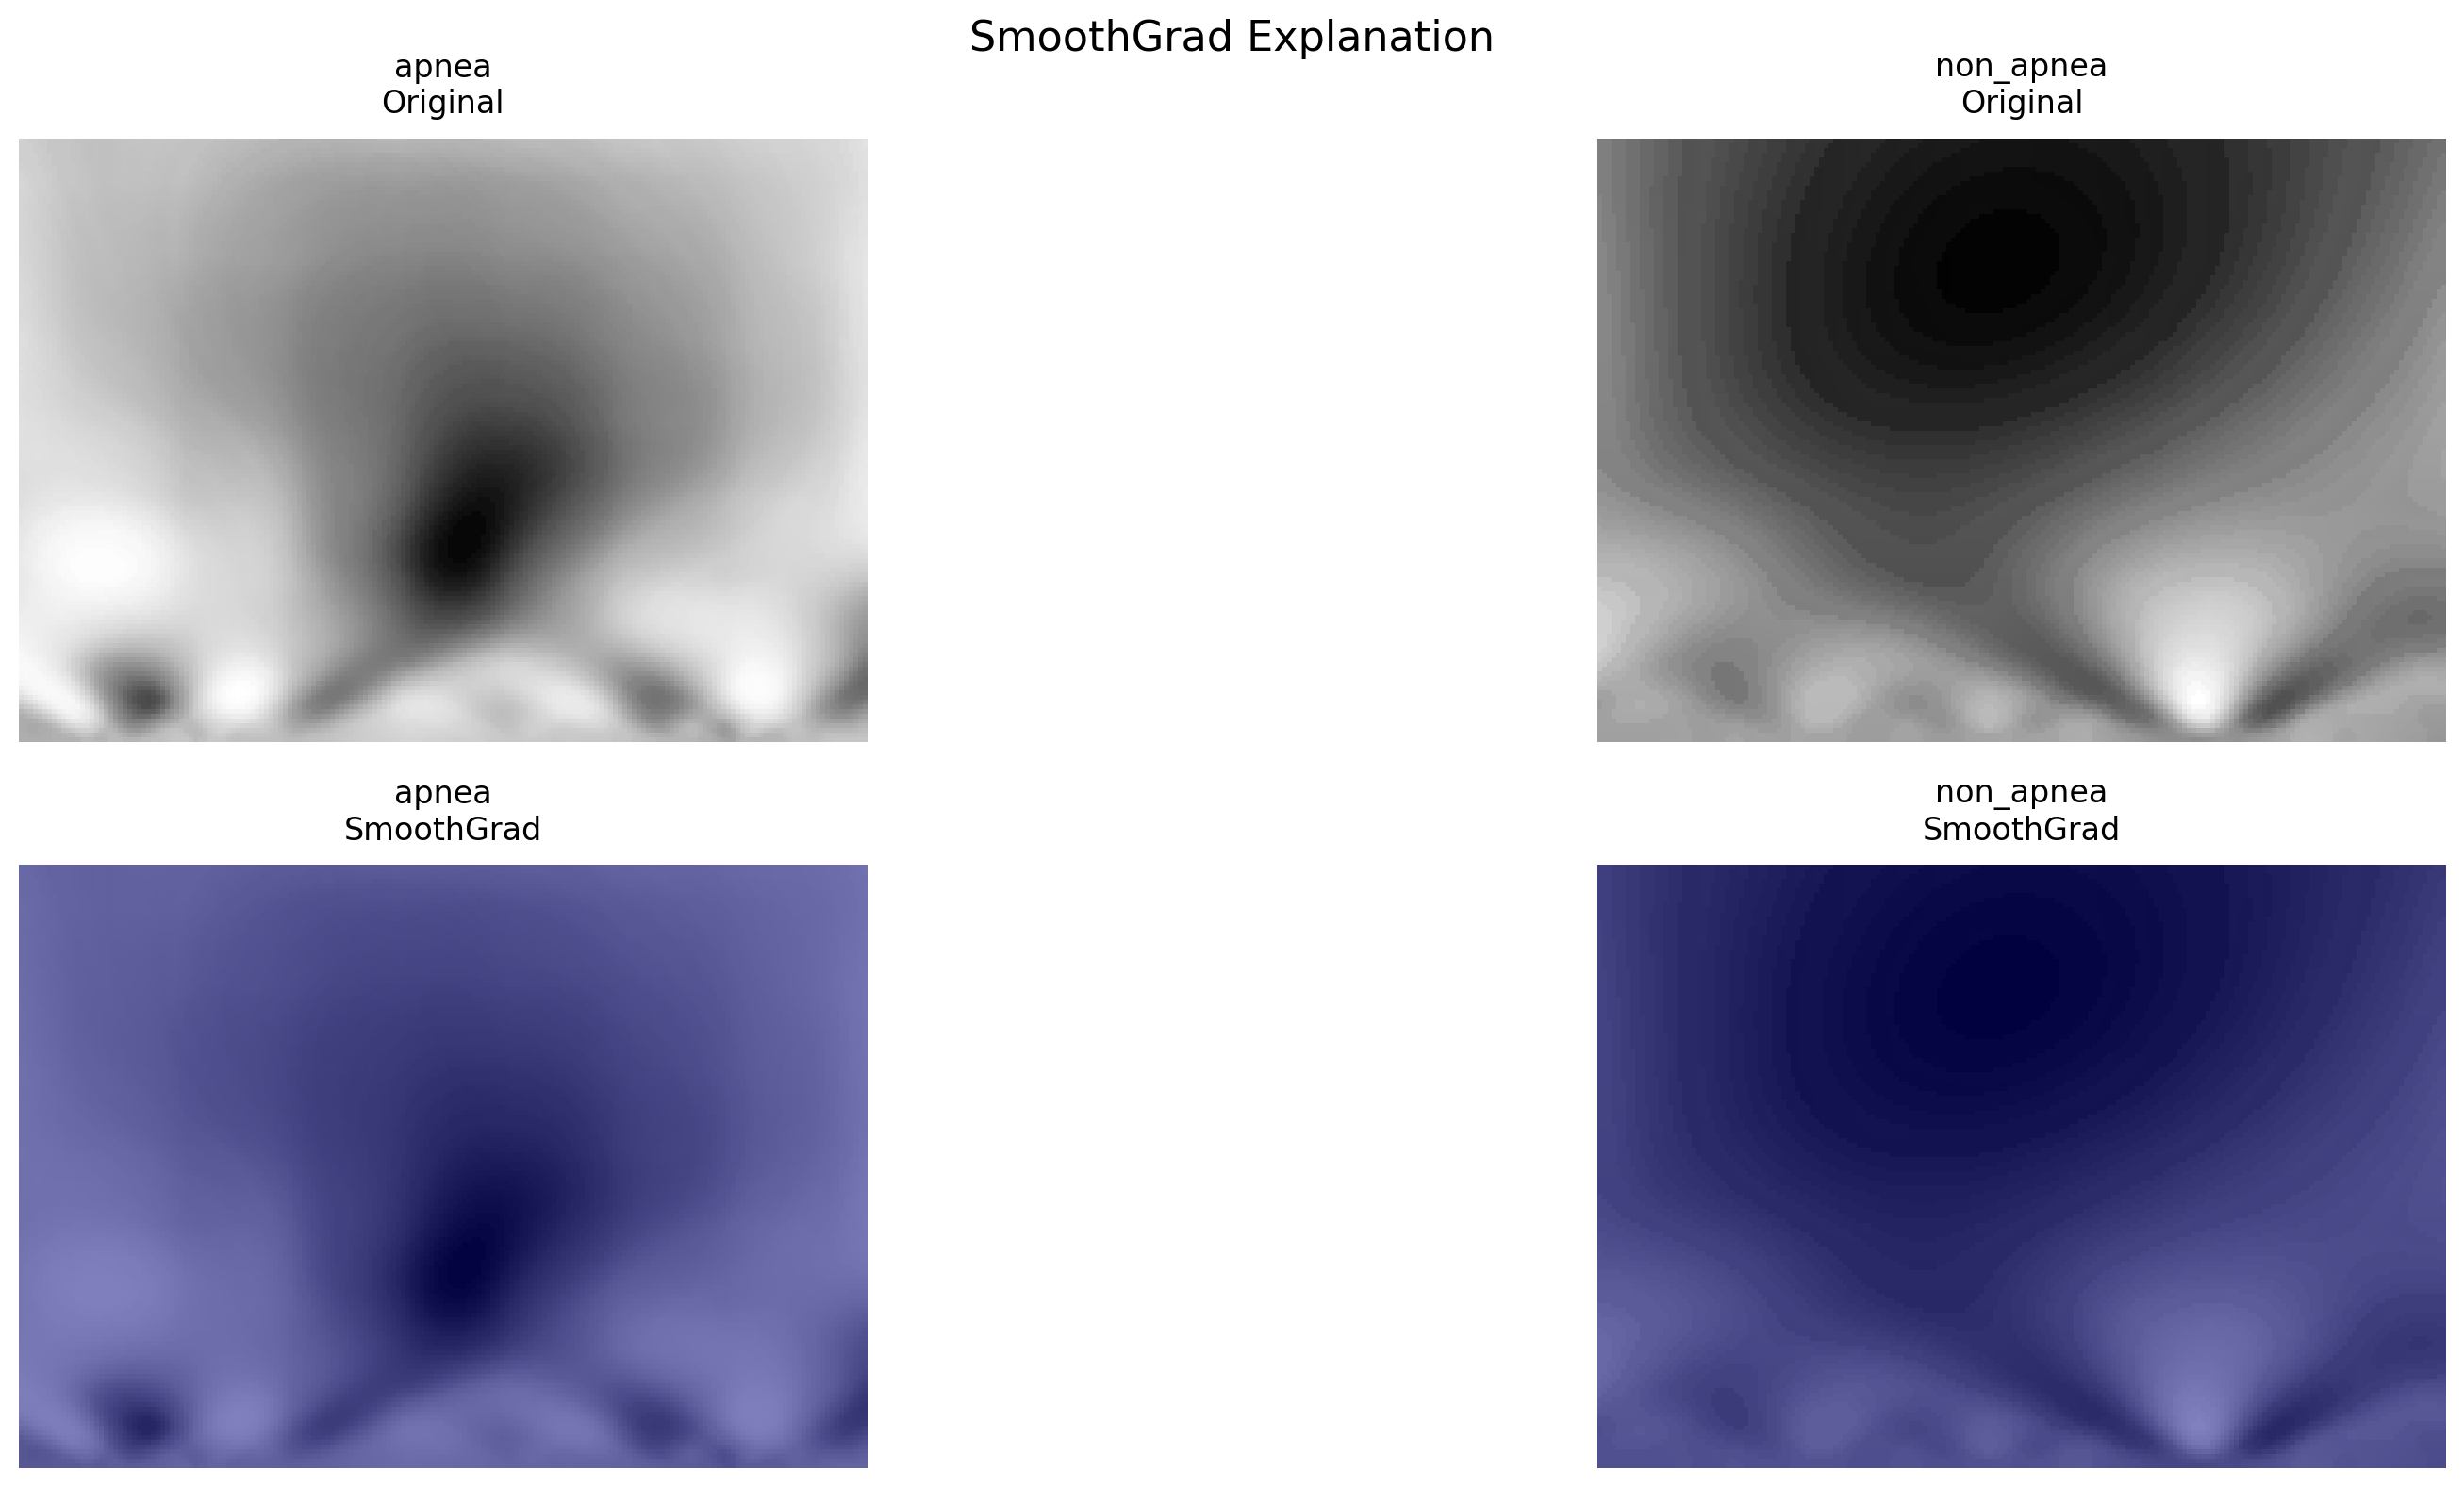


Generating SquareGrad explanations...


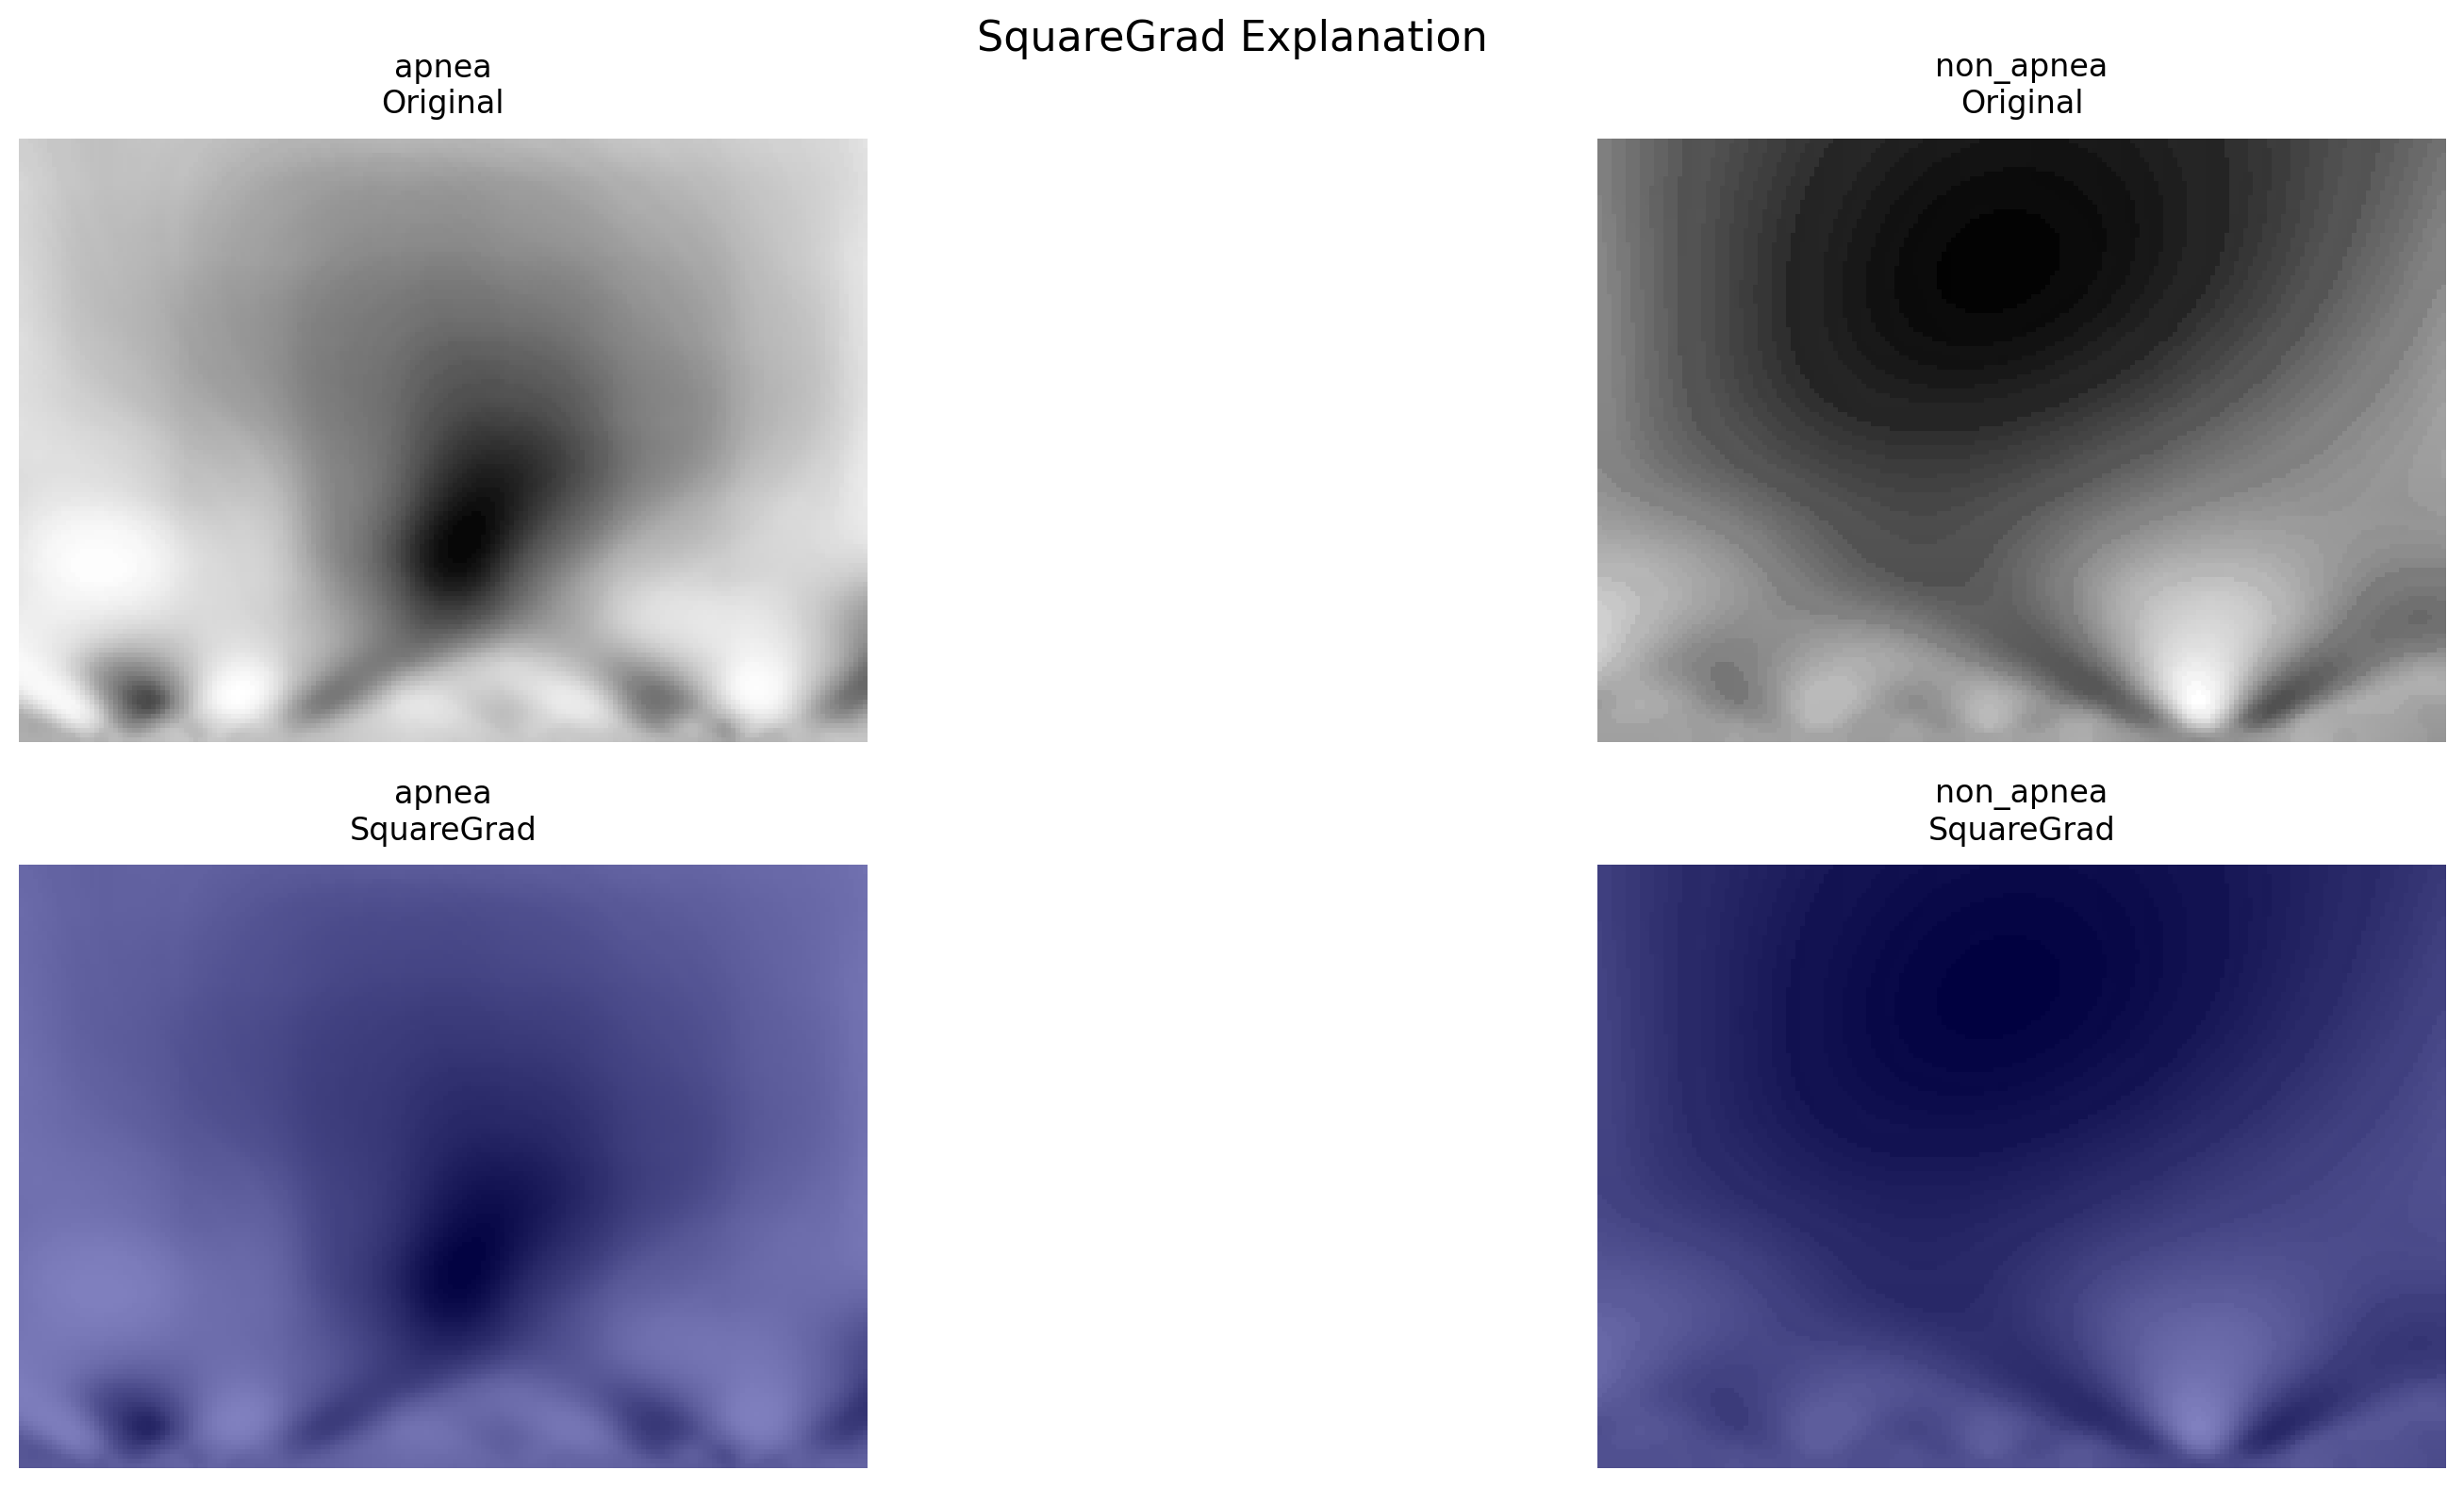


Generating VarGrad explanations...


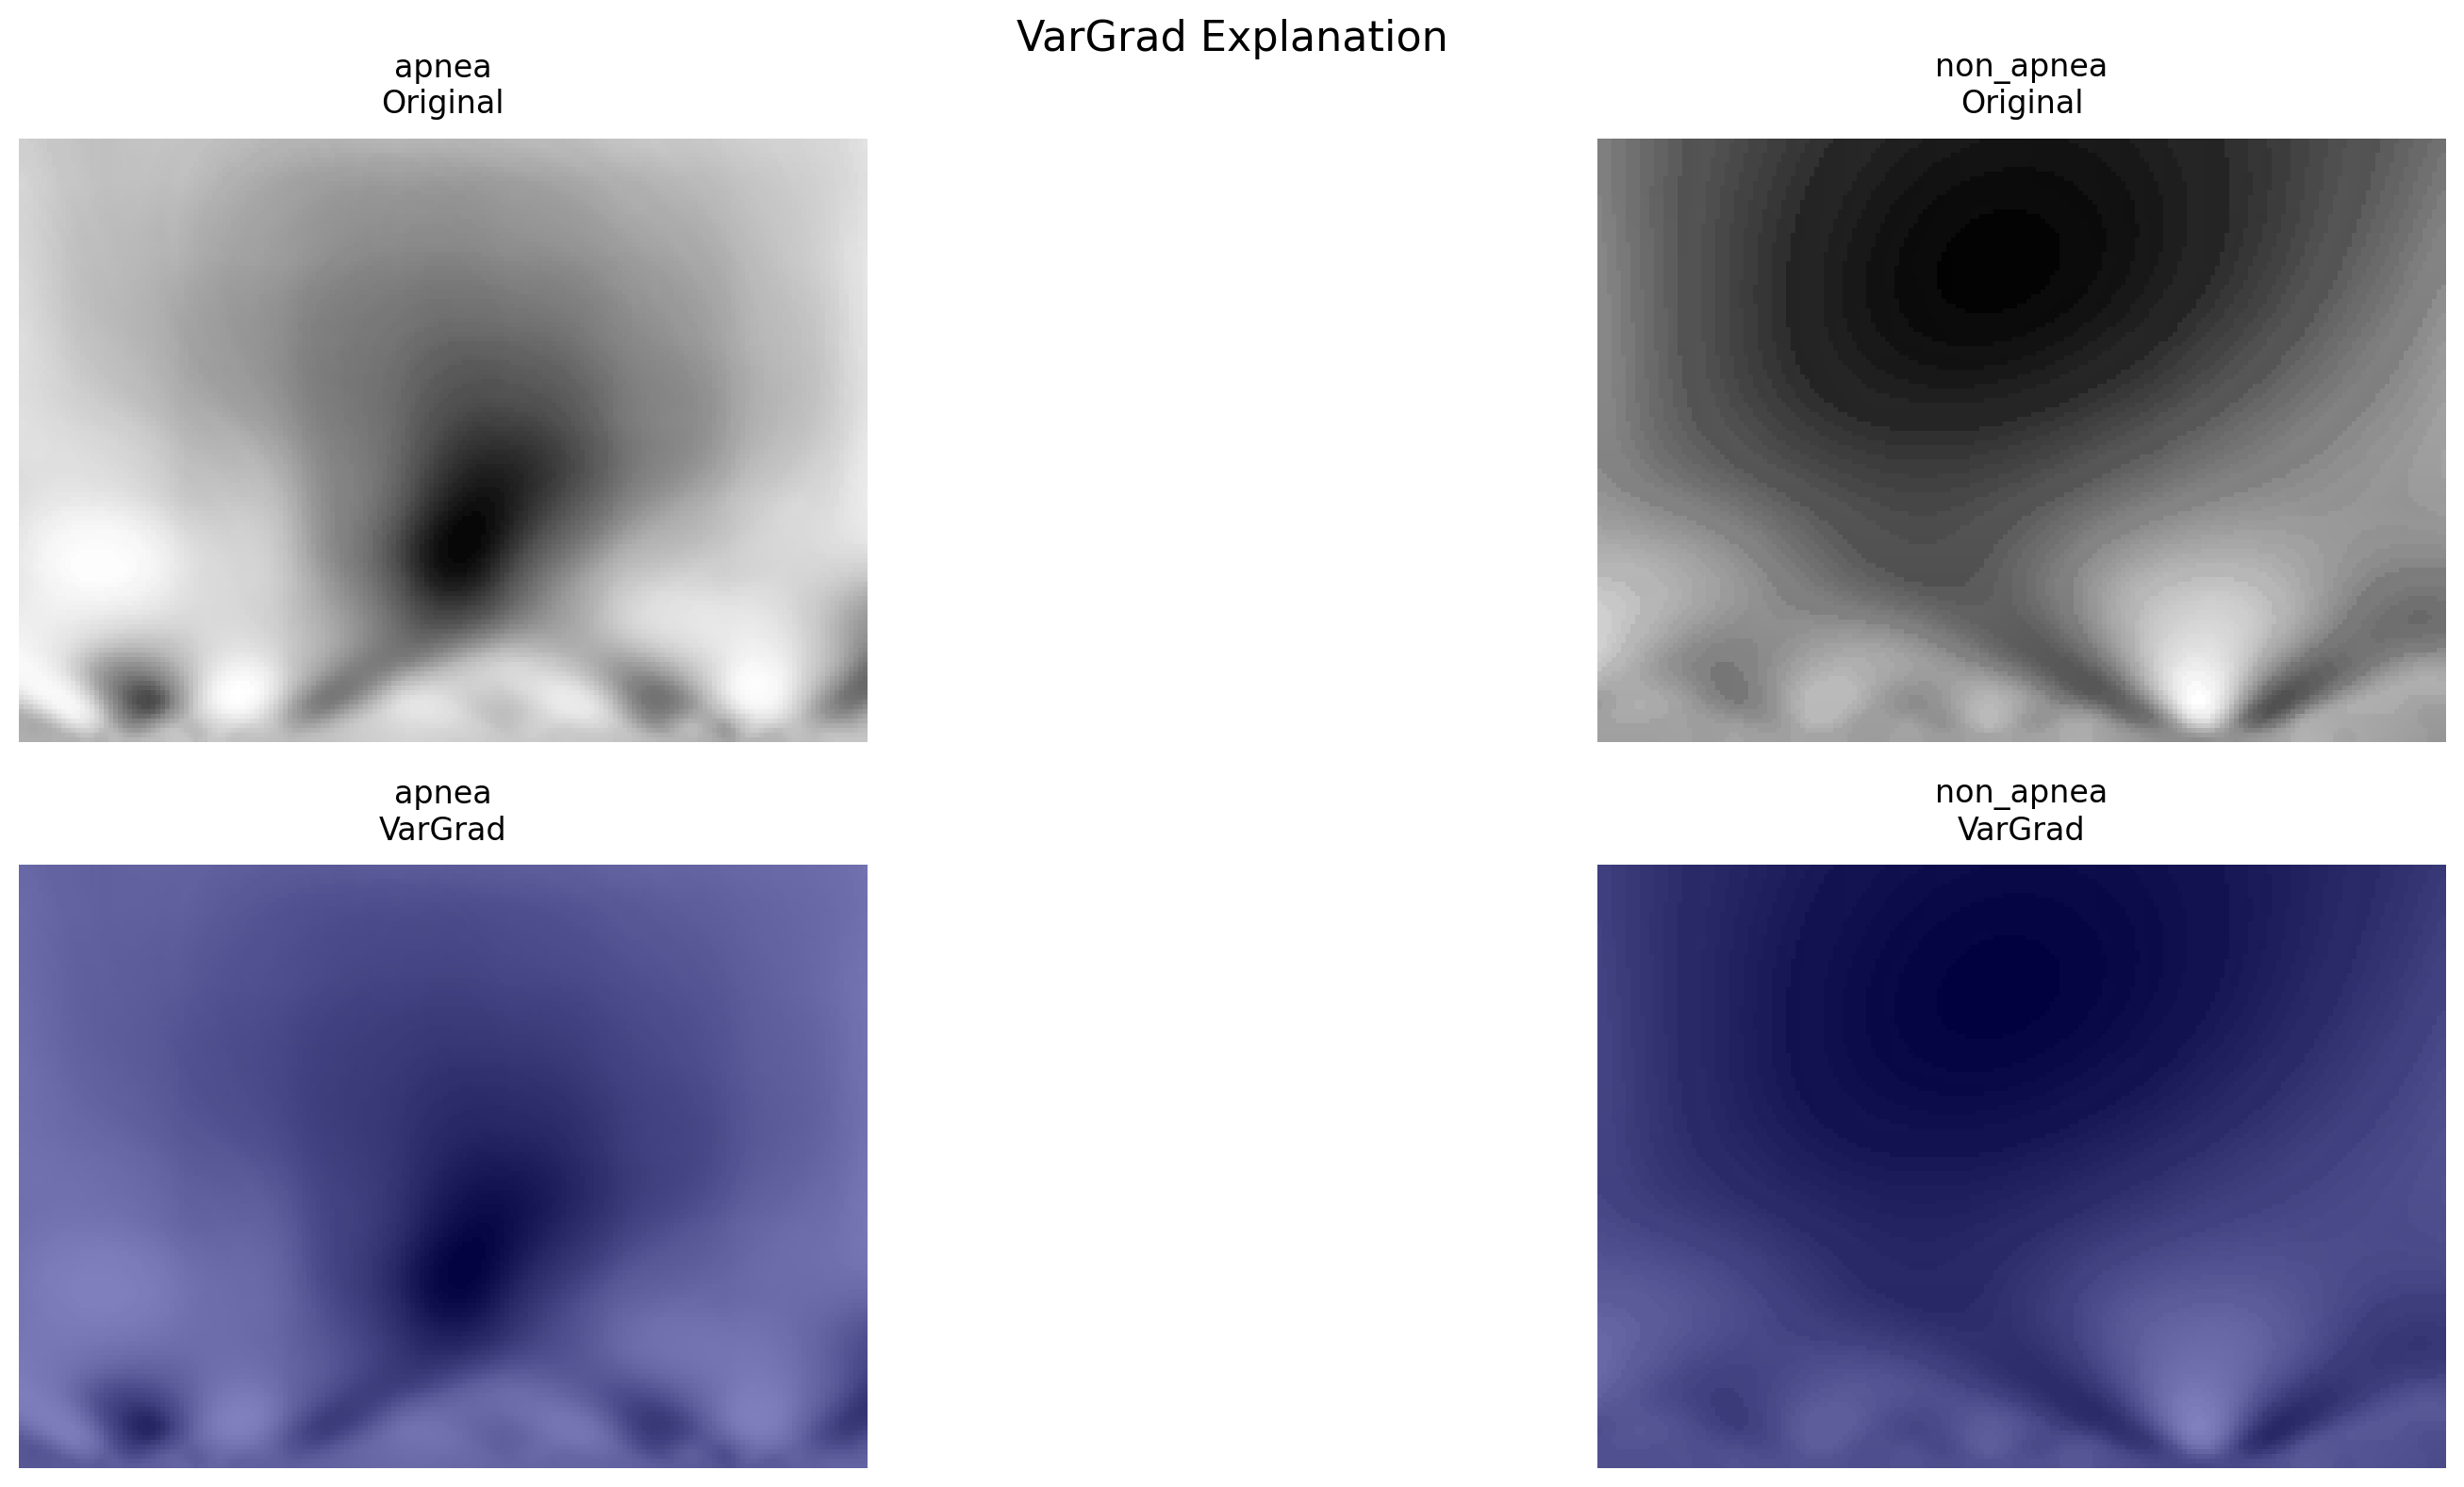


Generating GradCAM explanations...


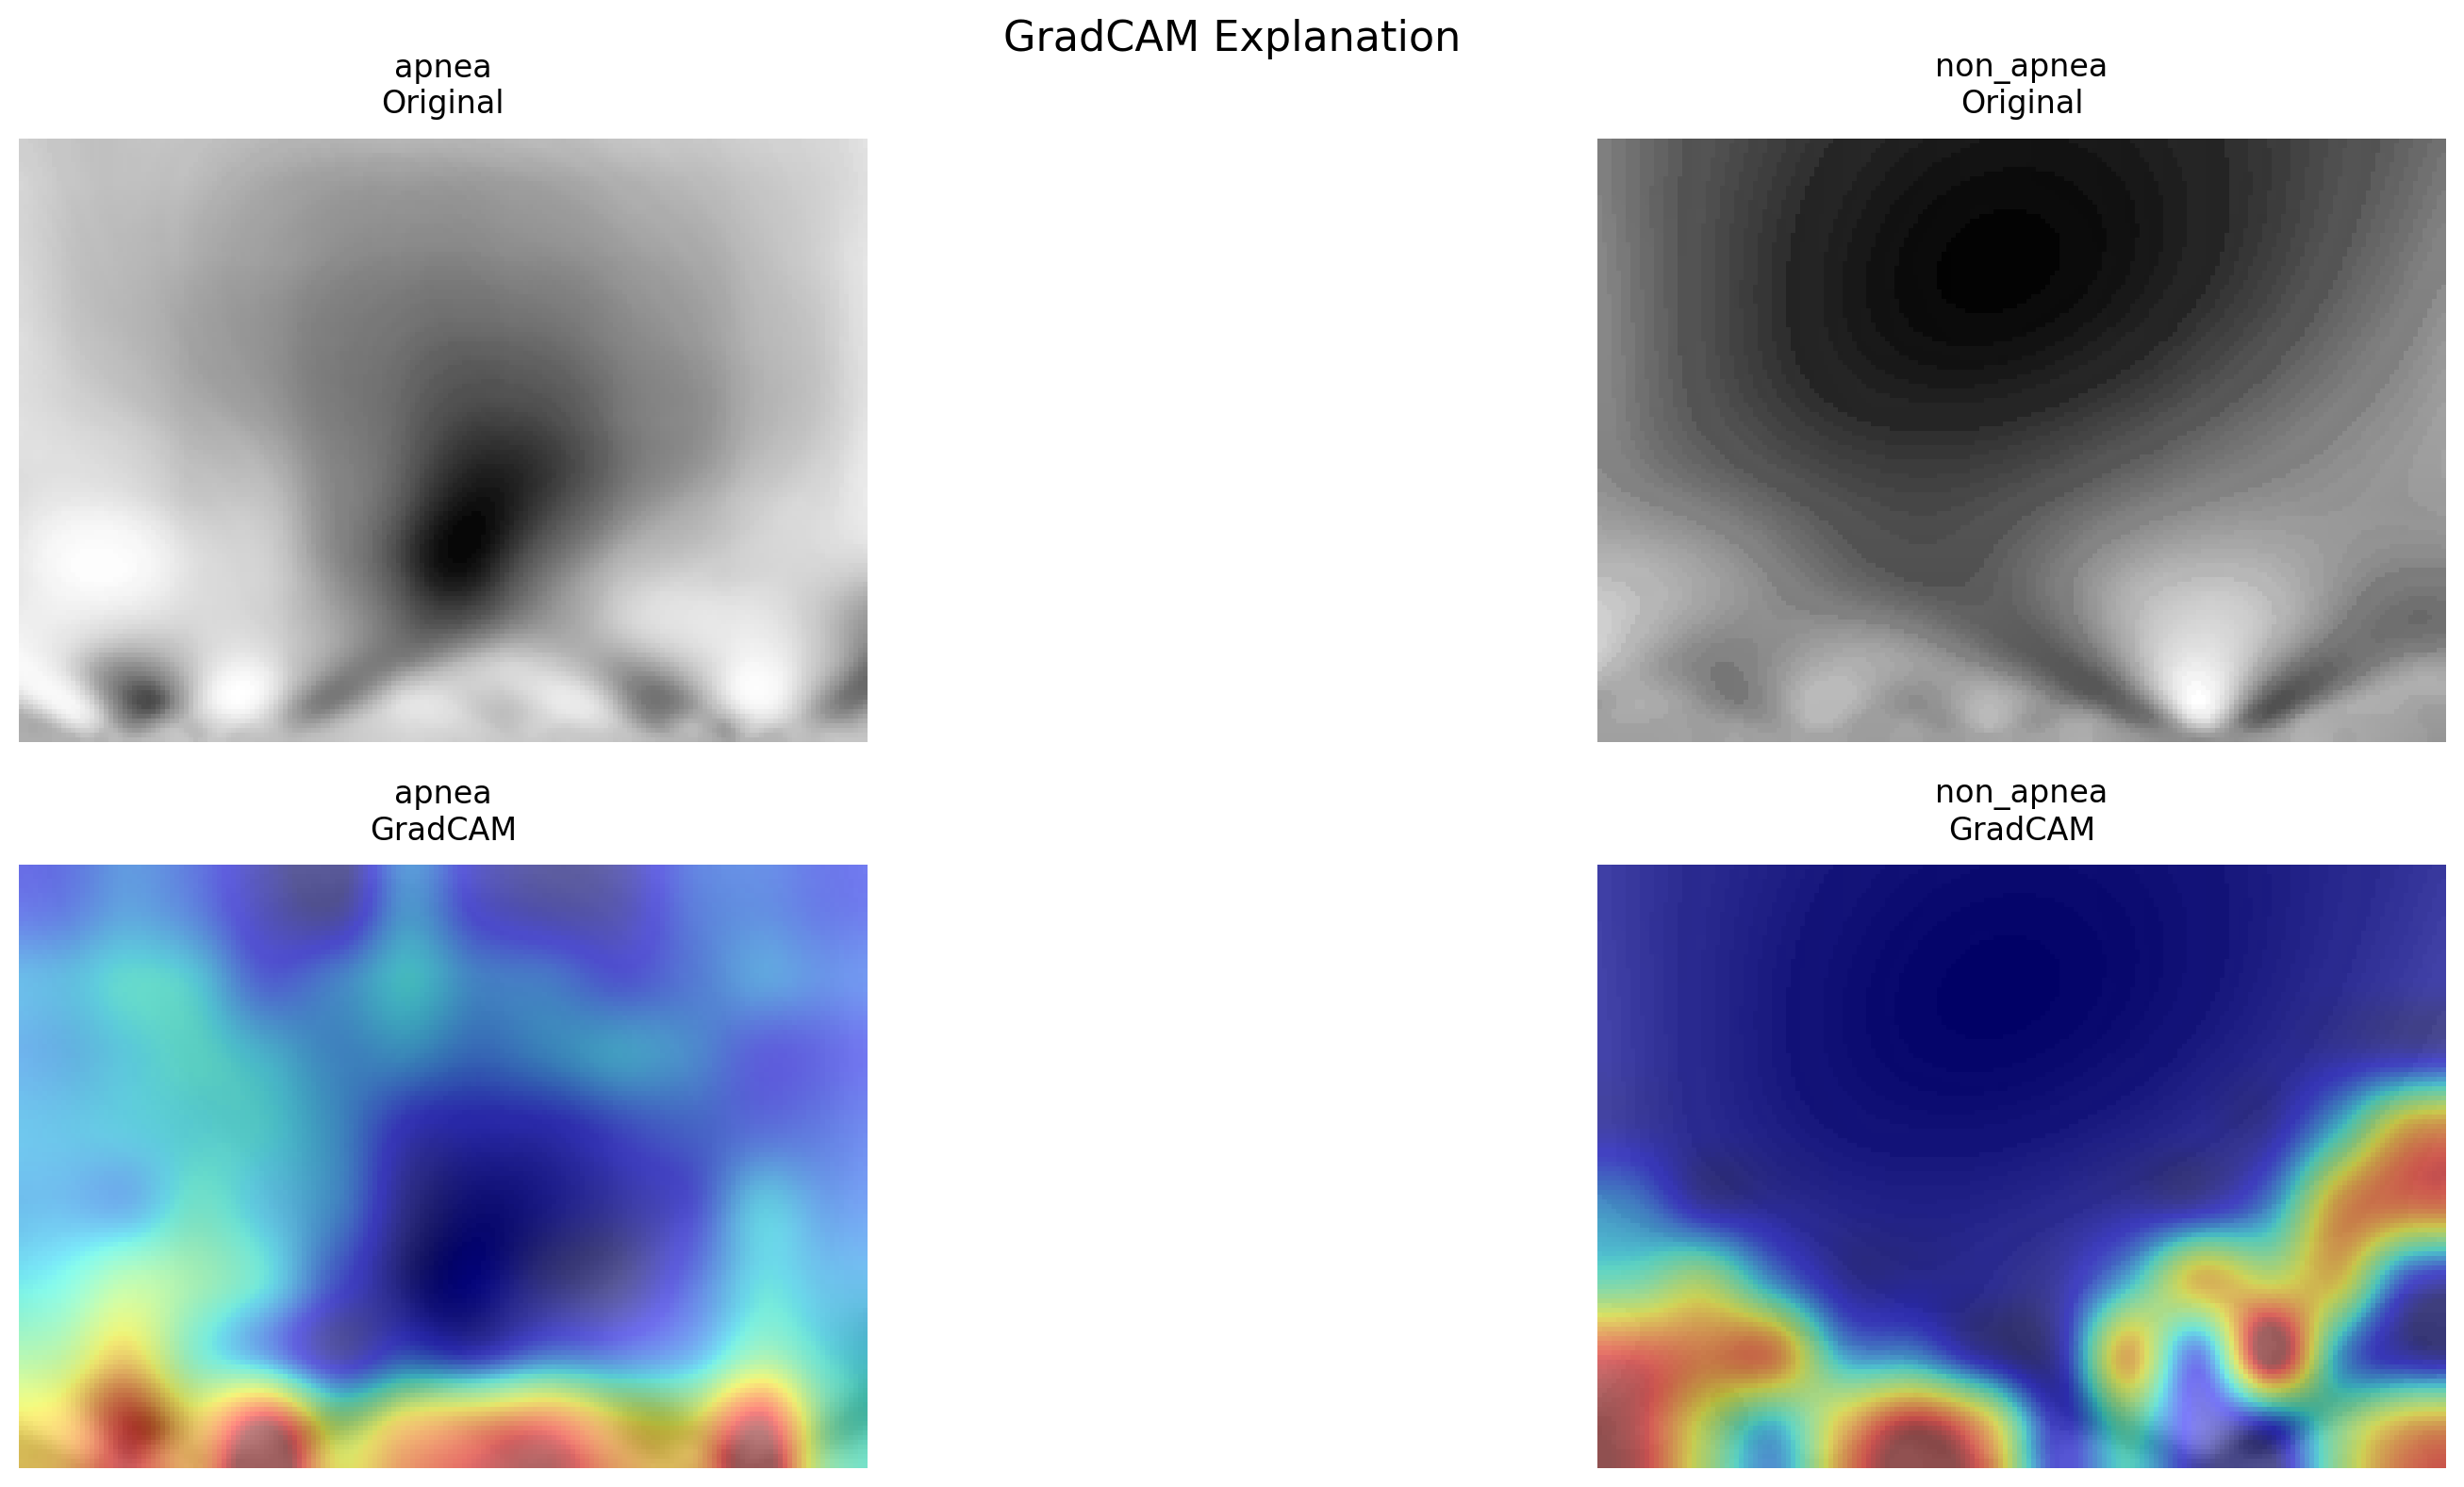


Generating Occlusion explanations...


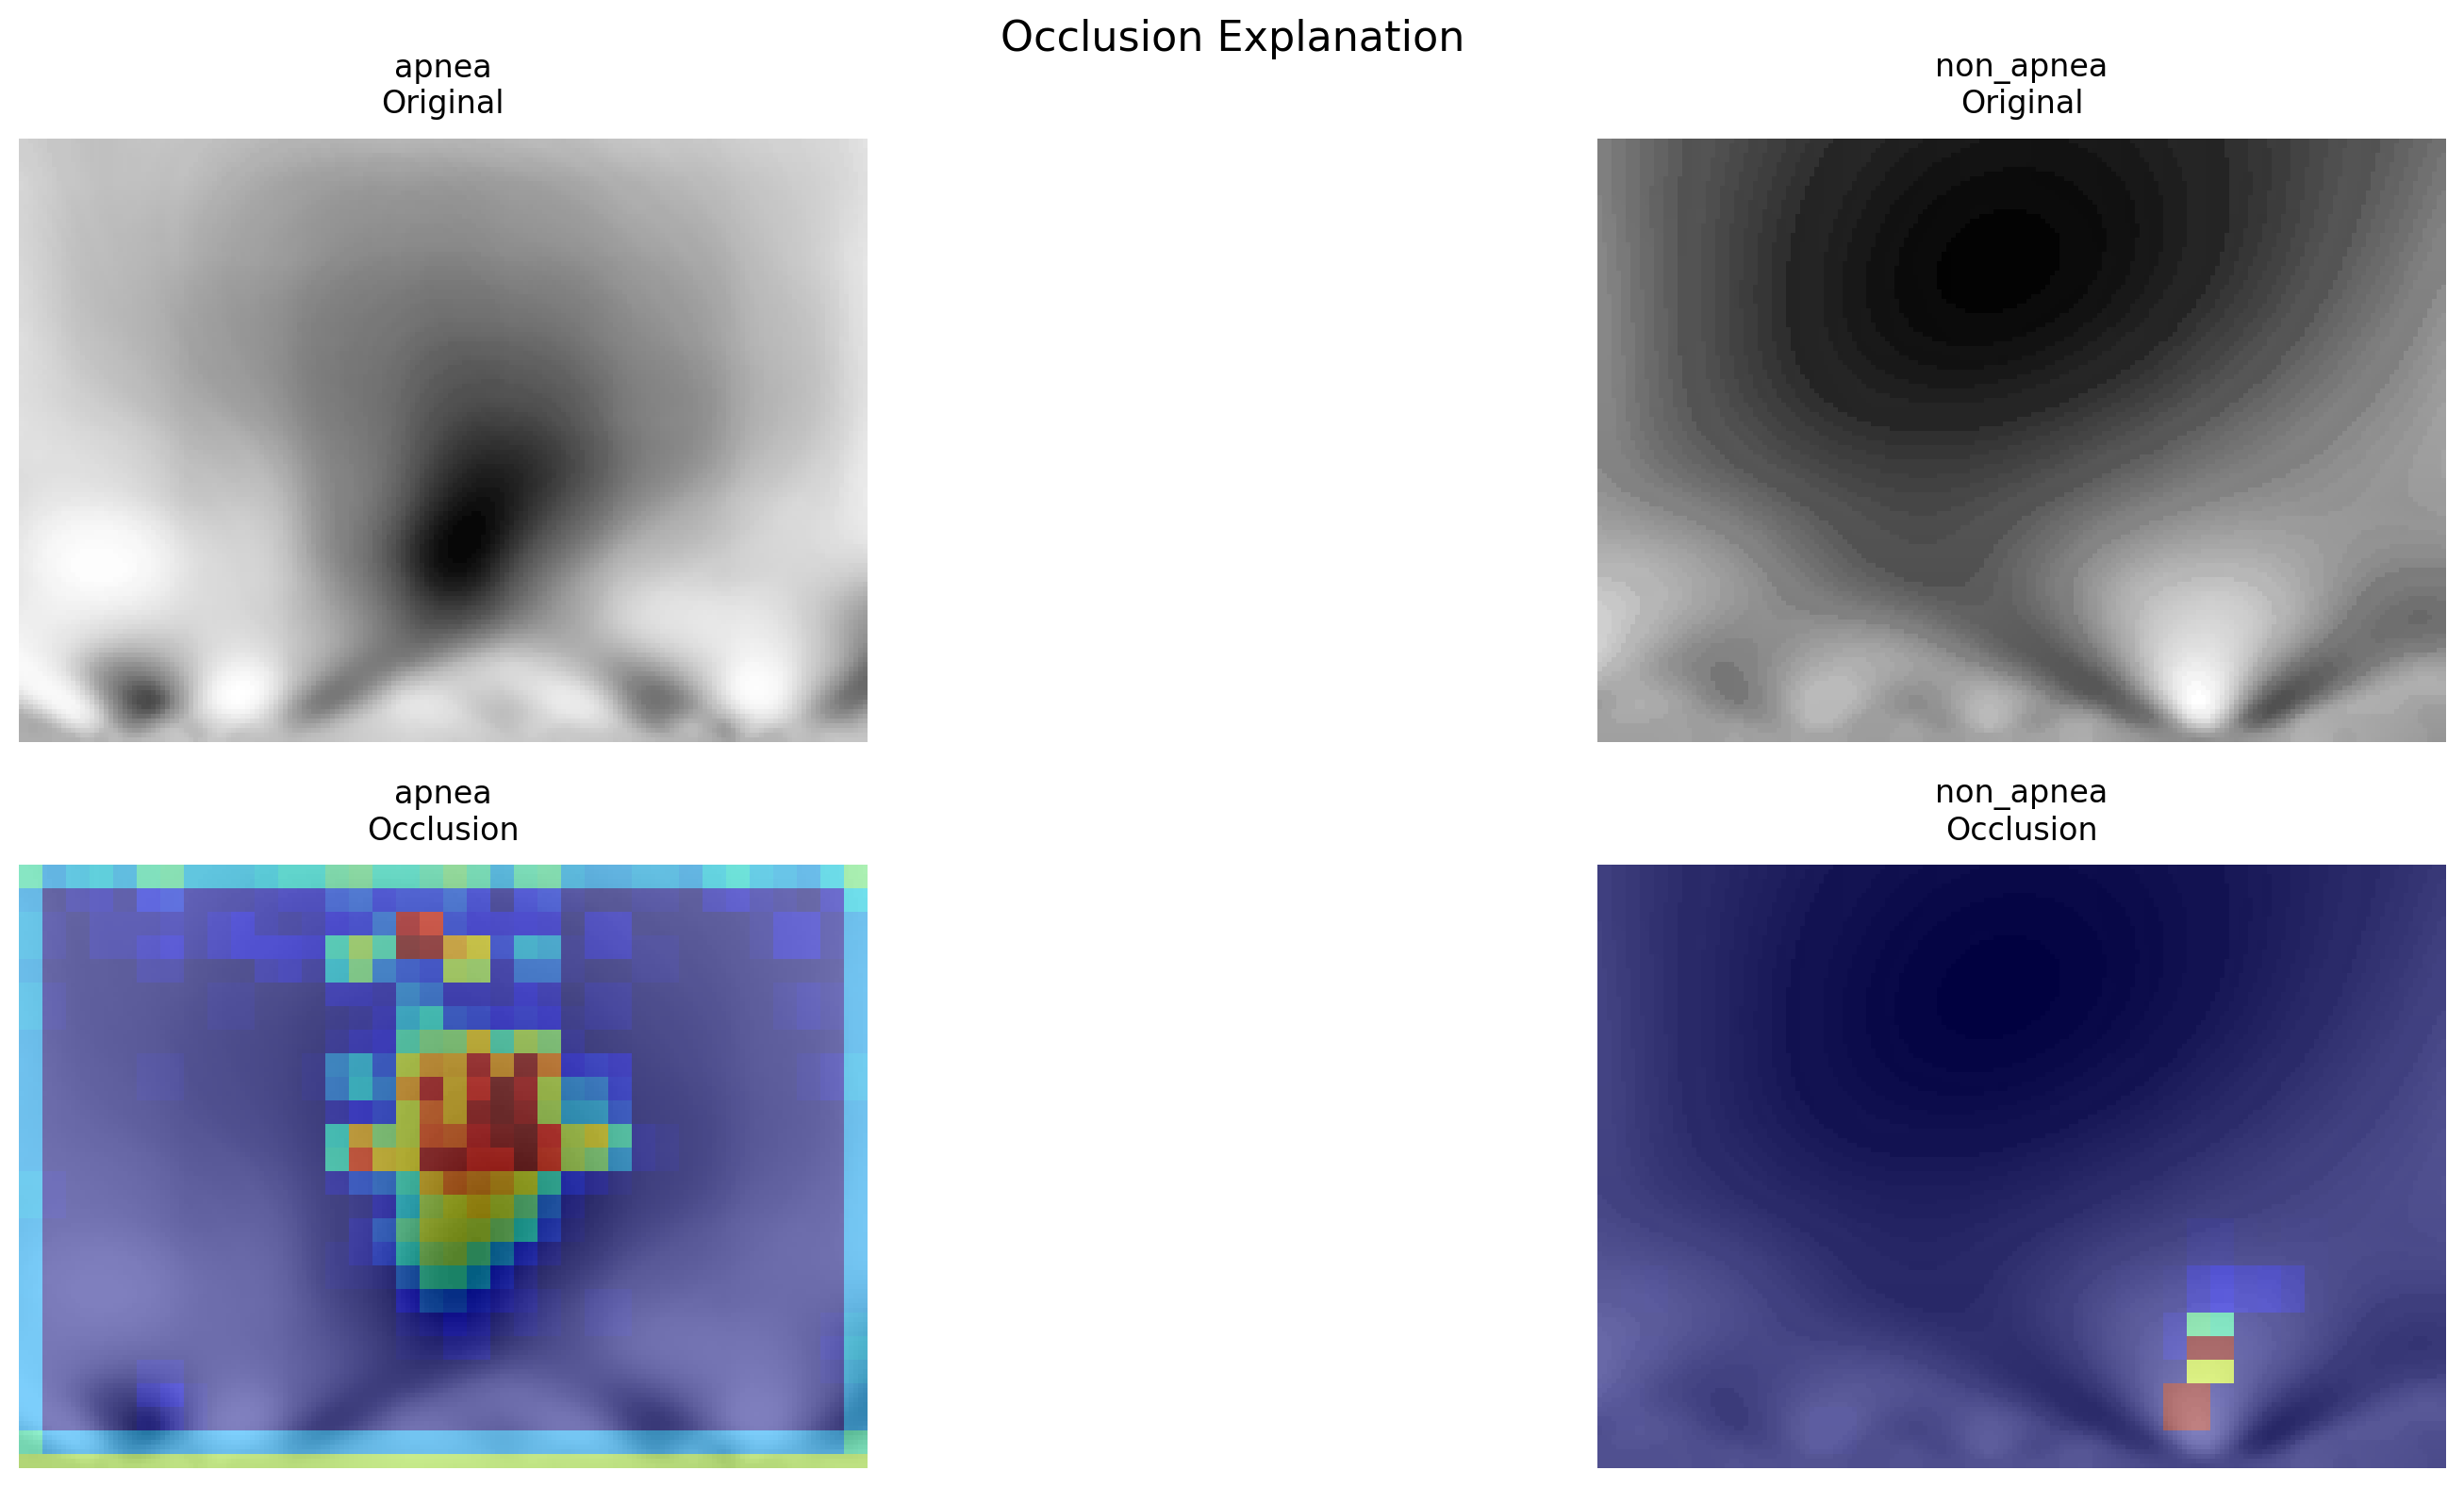


Generating Rise explanations...


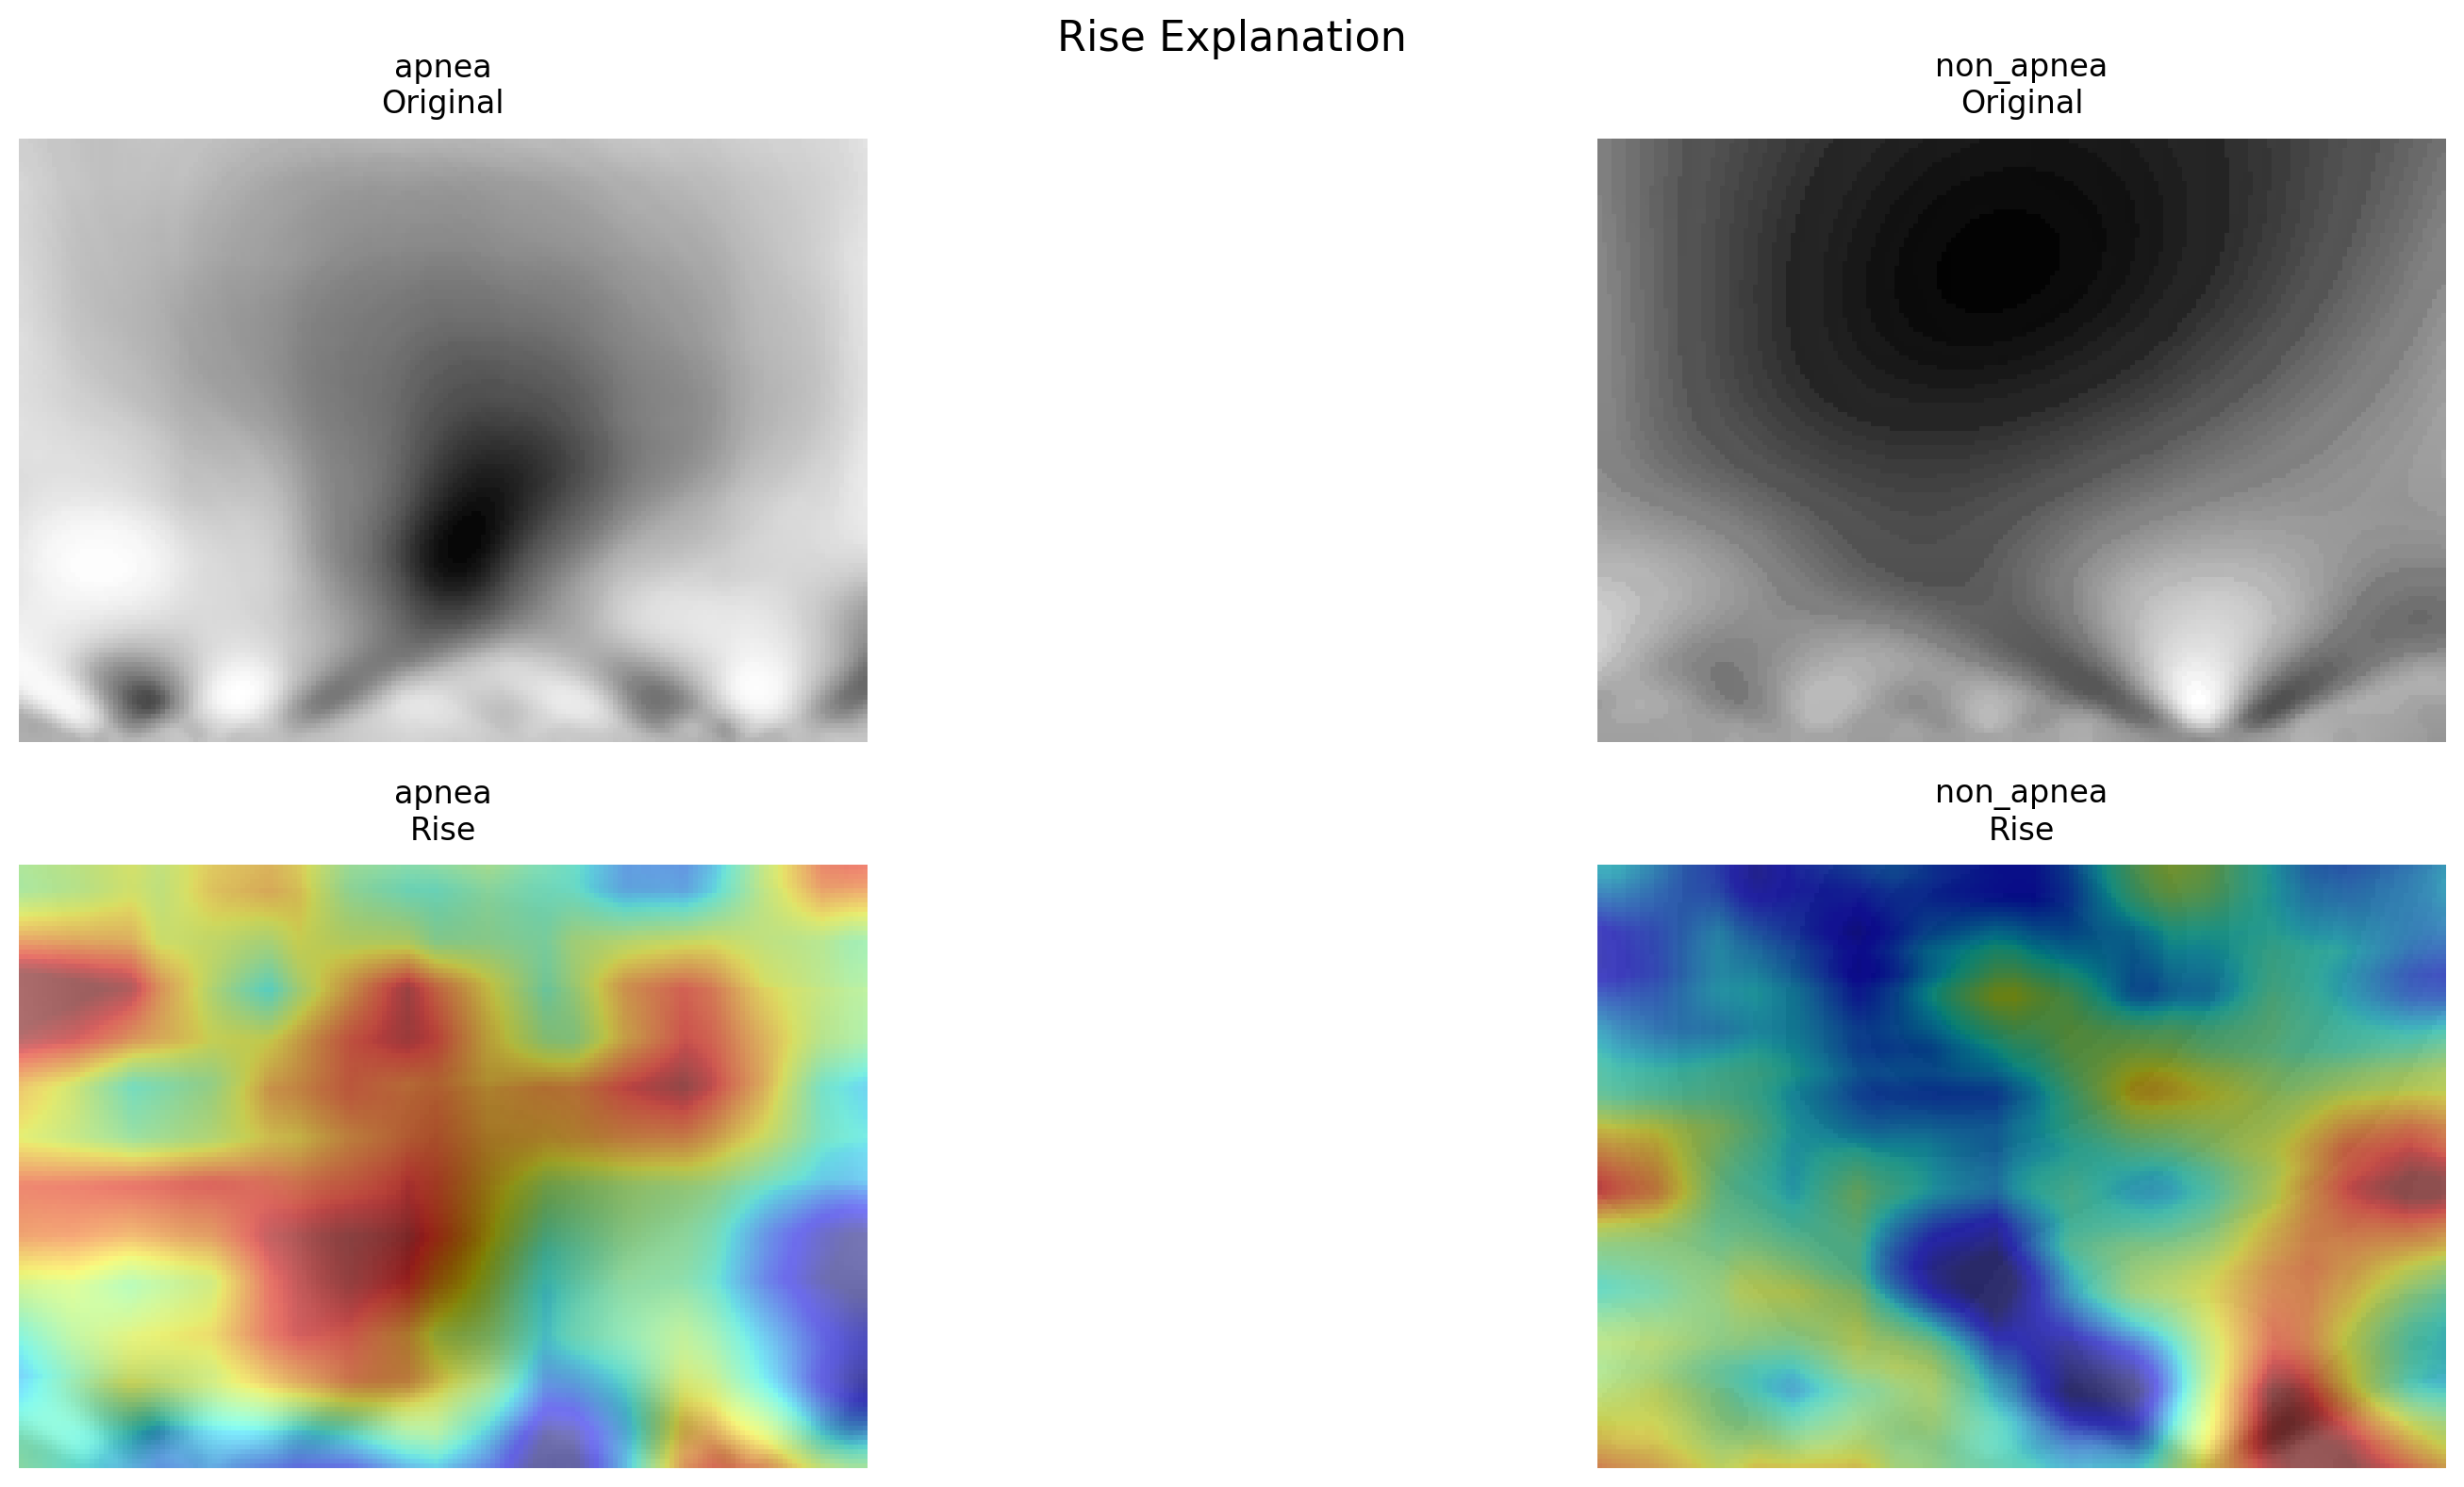


Generating SobolAttributionMethod explanations...


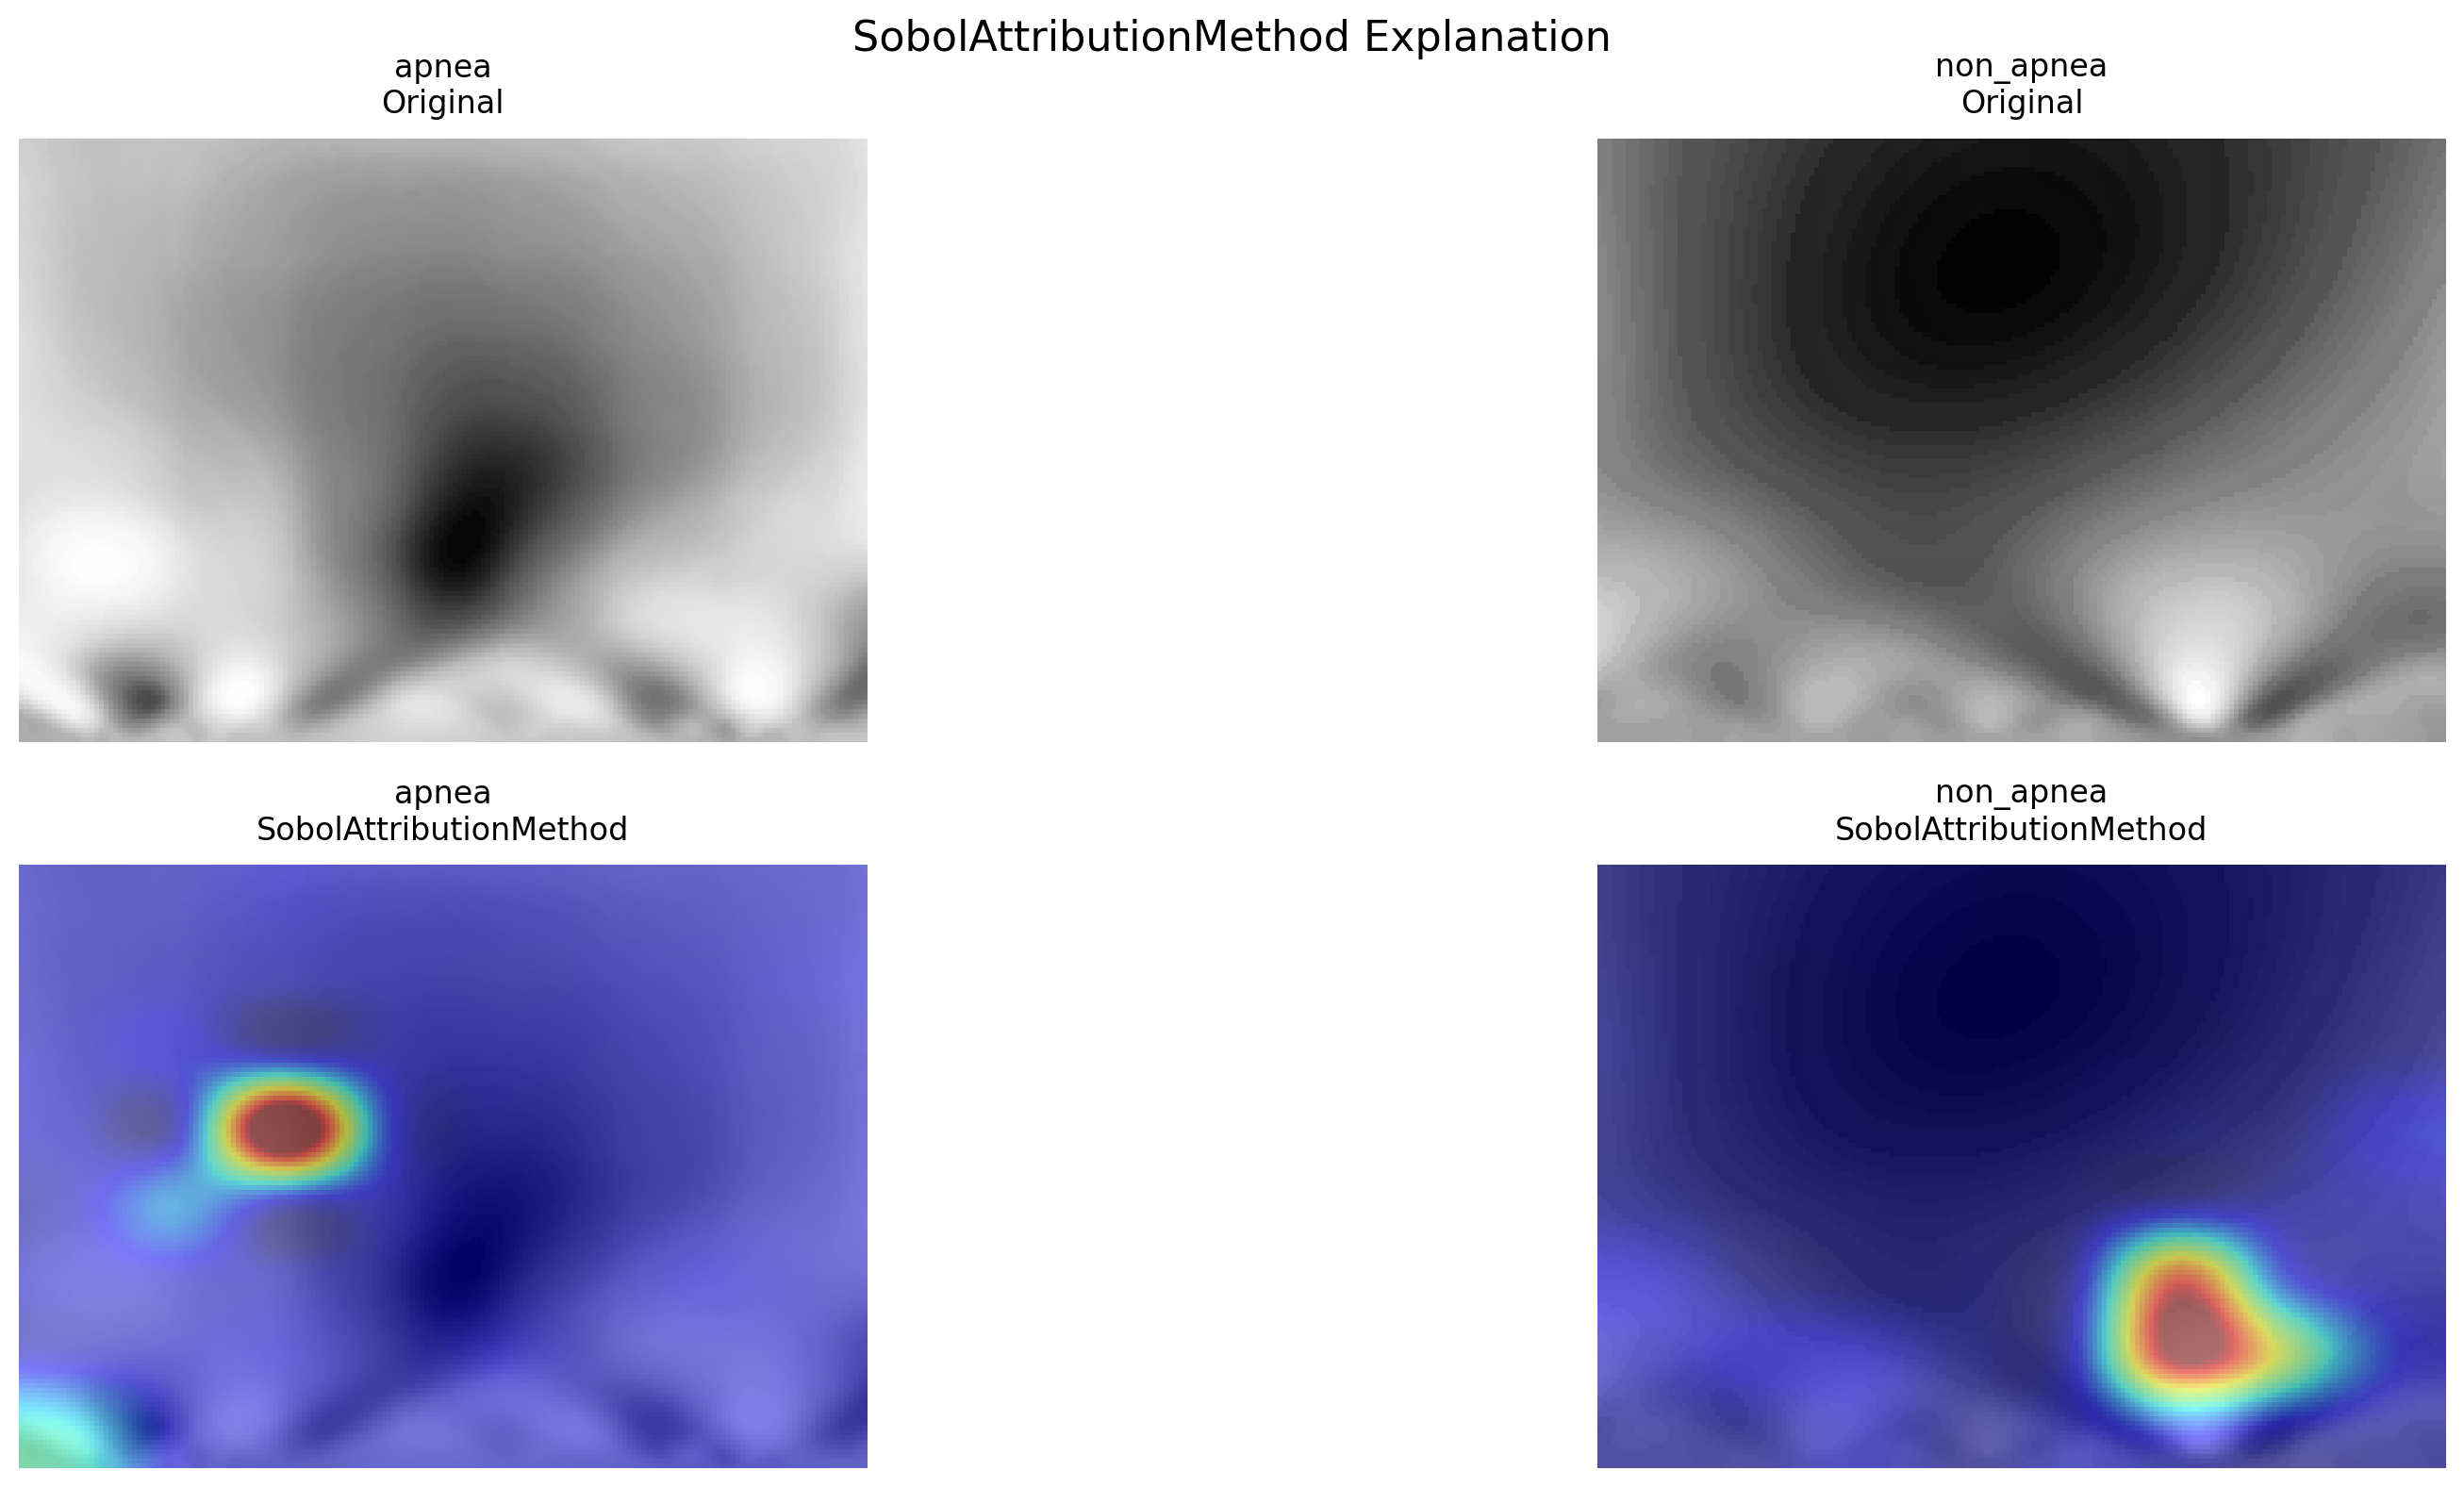


Generating Lime explanations...


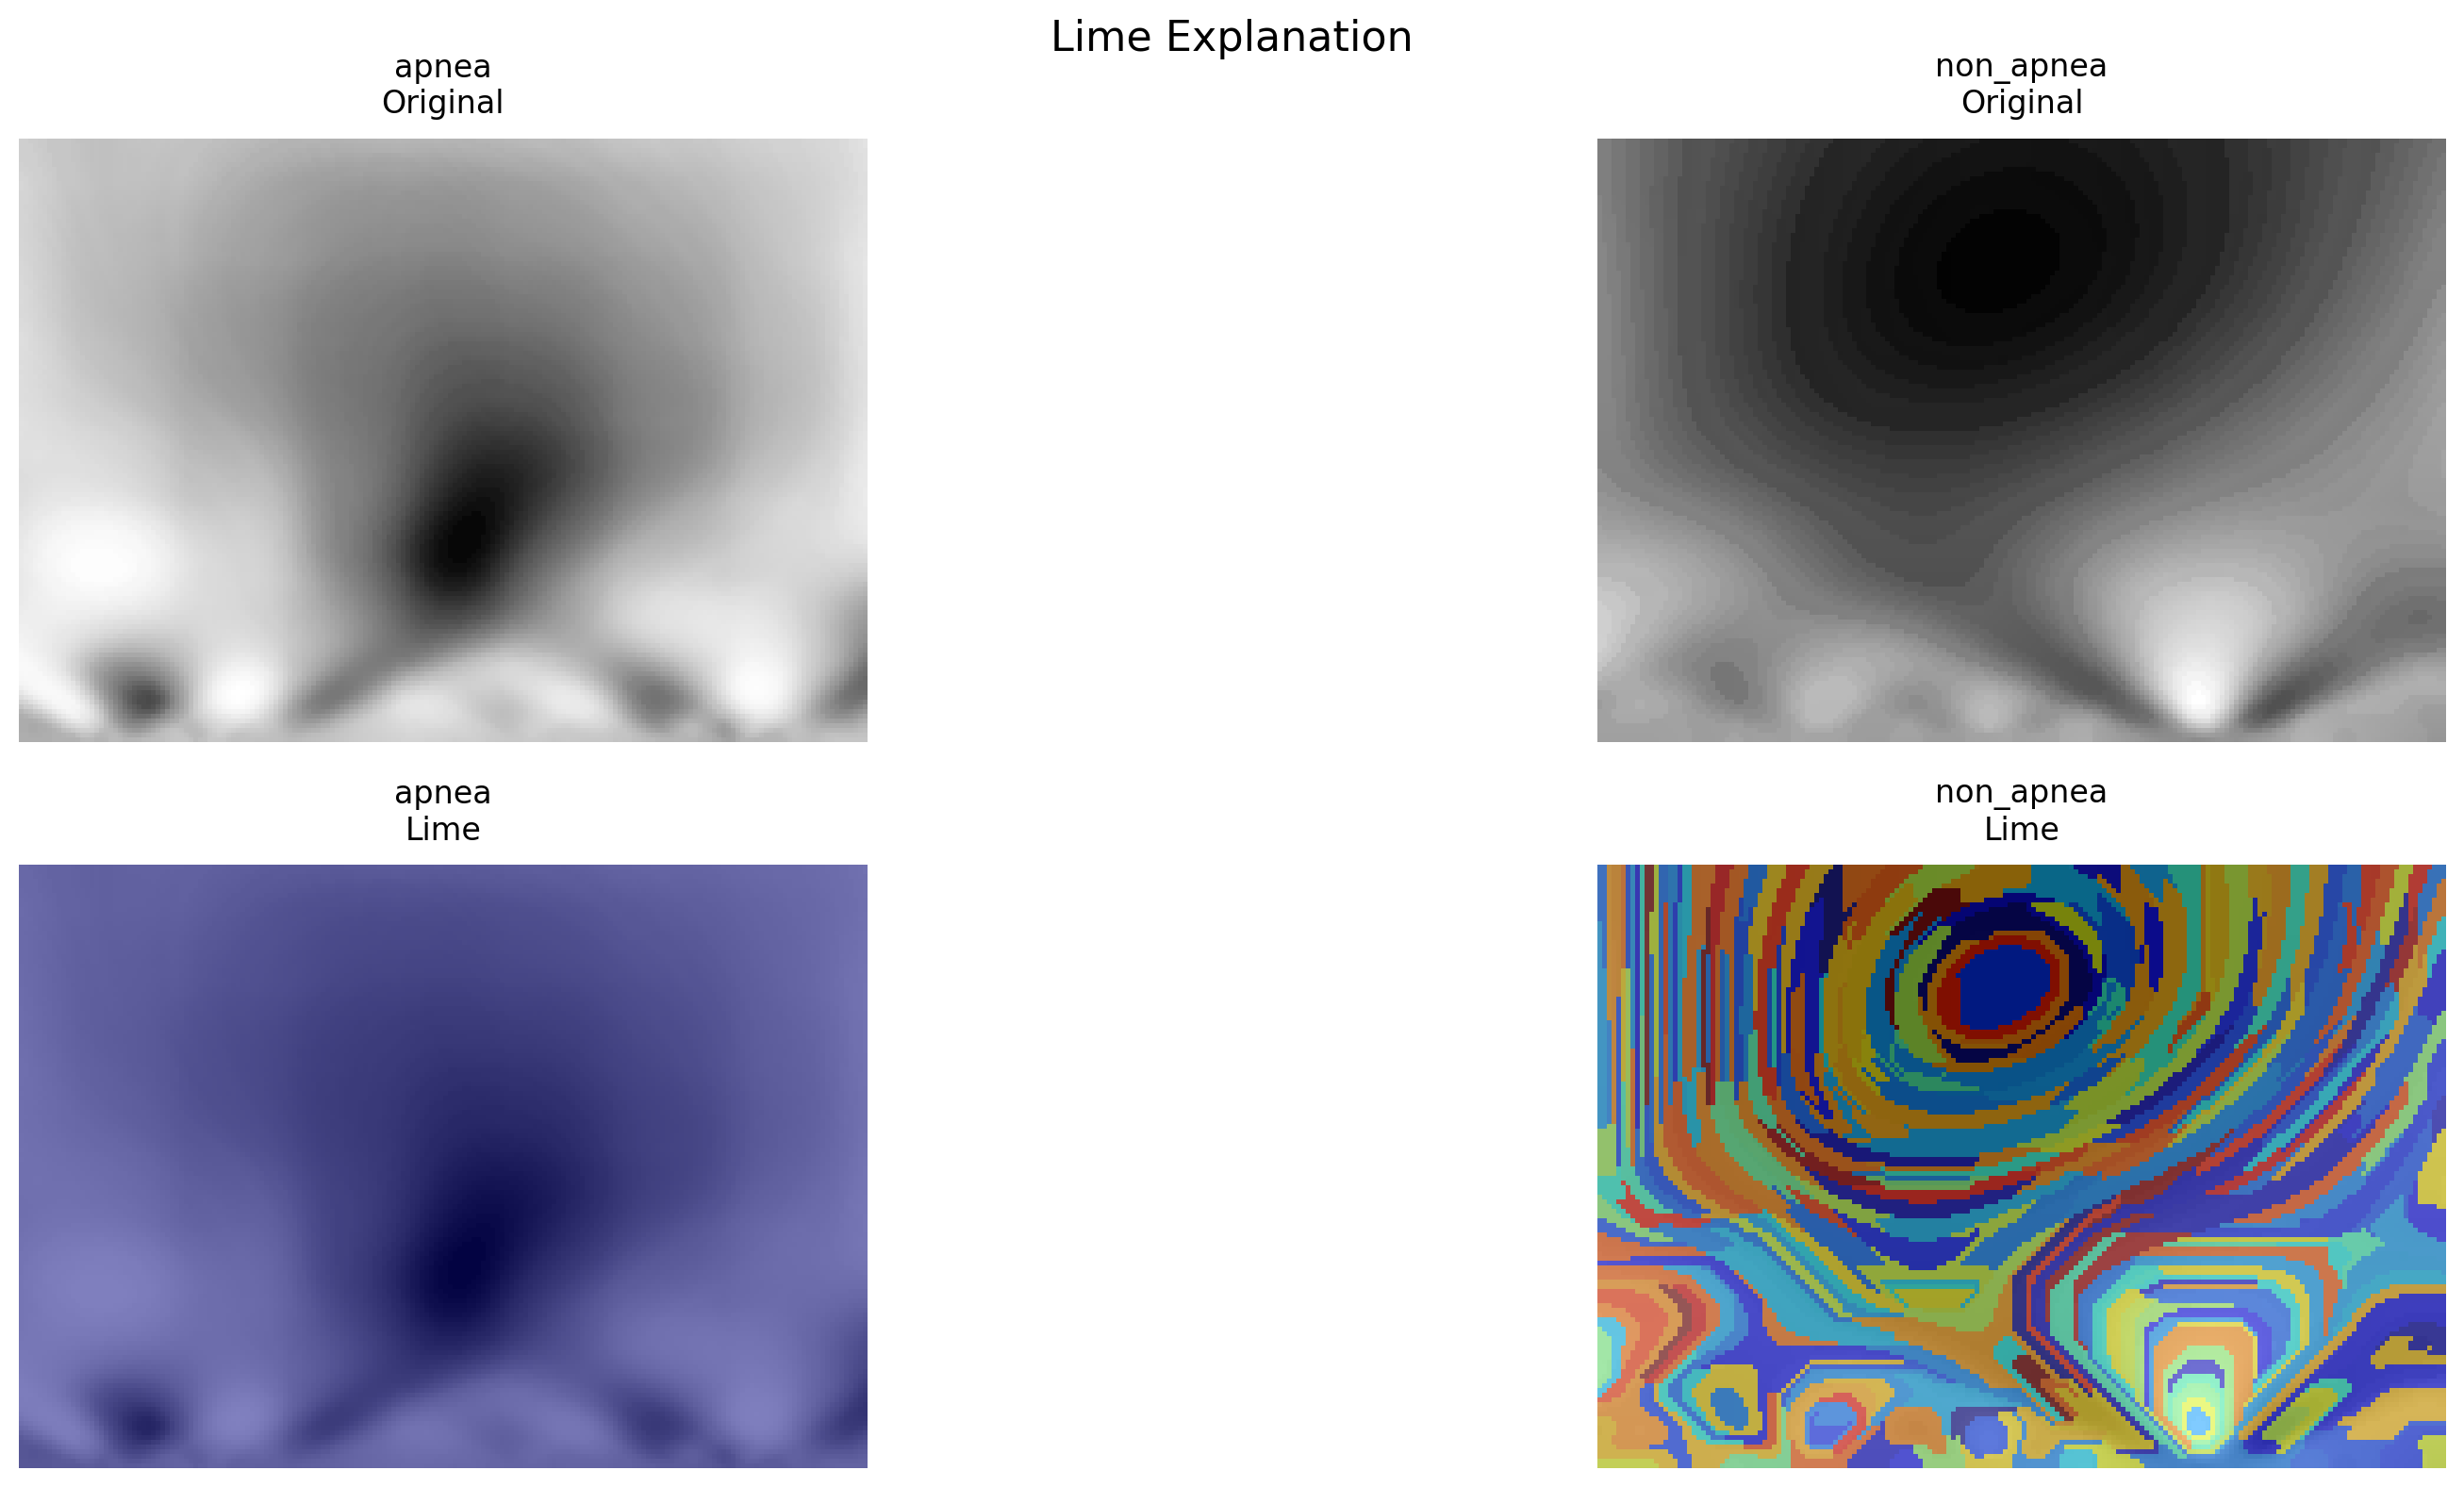


Generating KernelShap explanations...


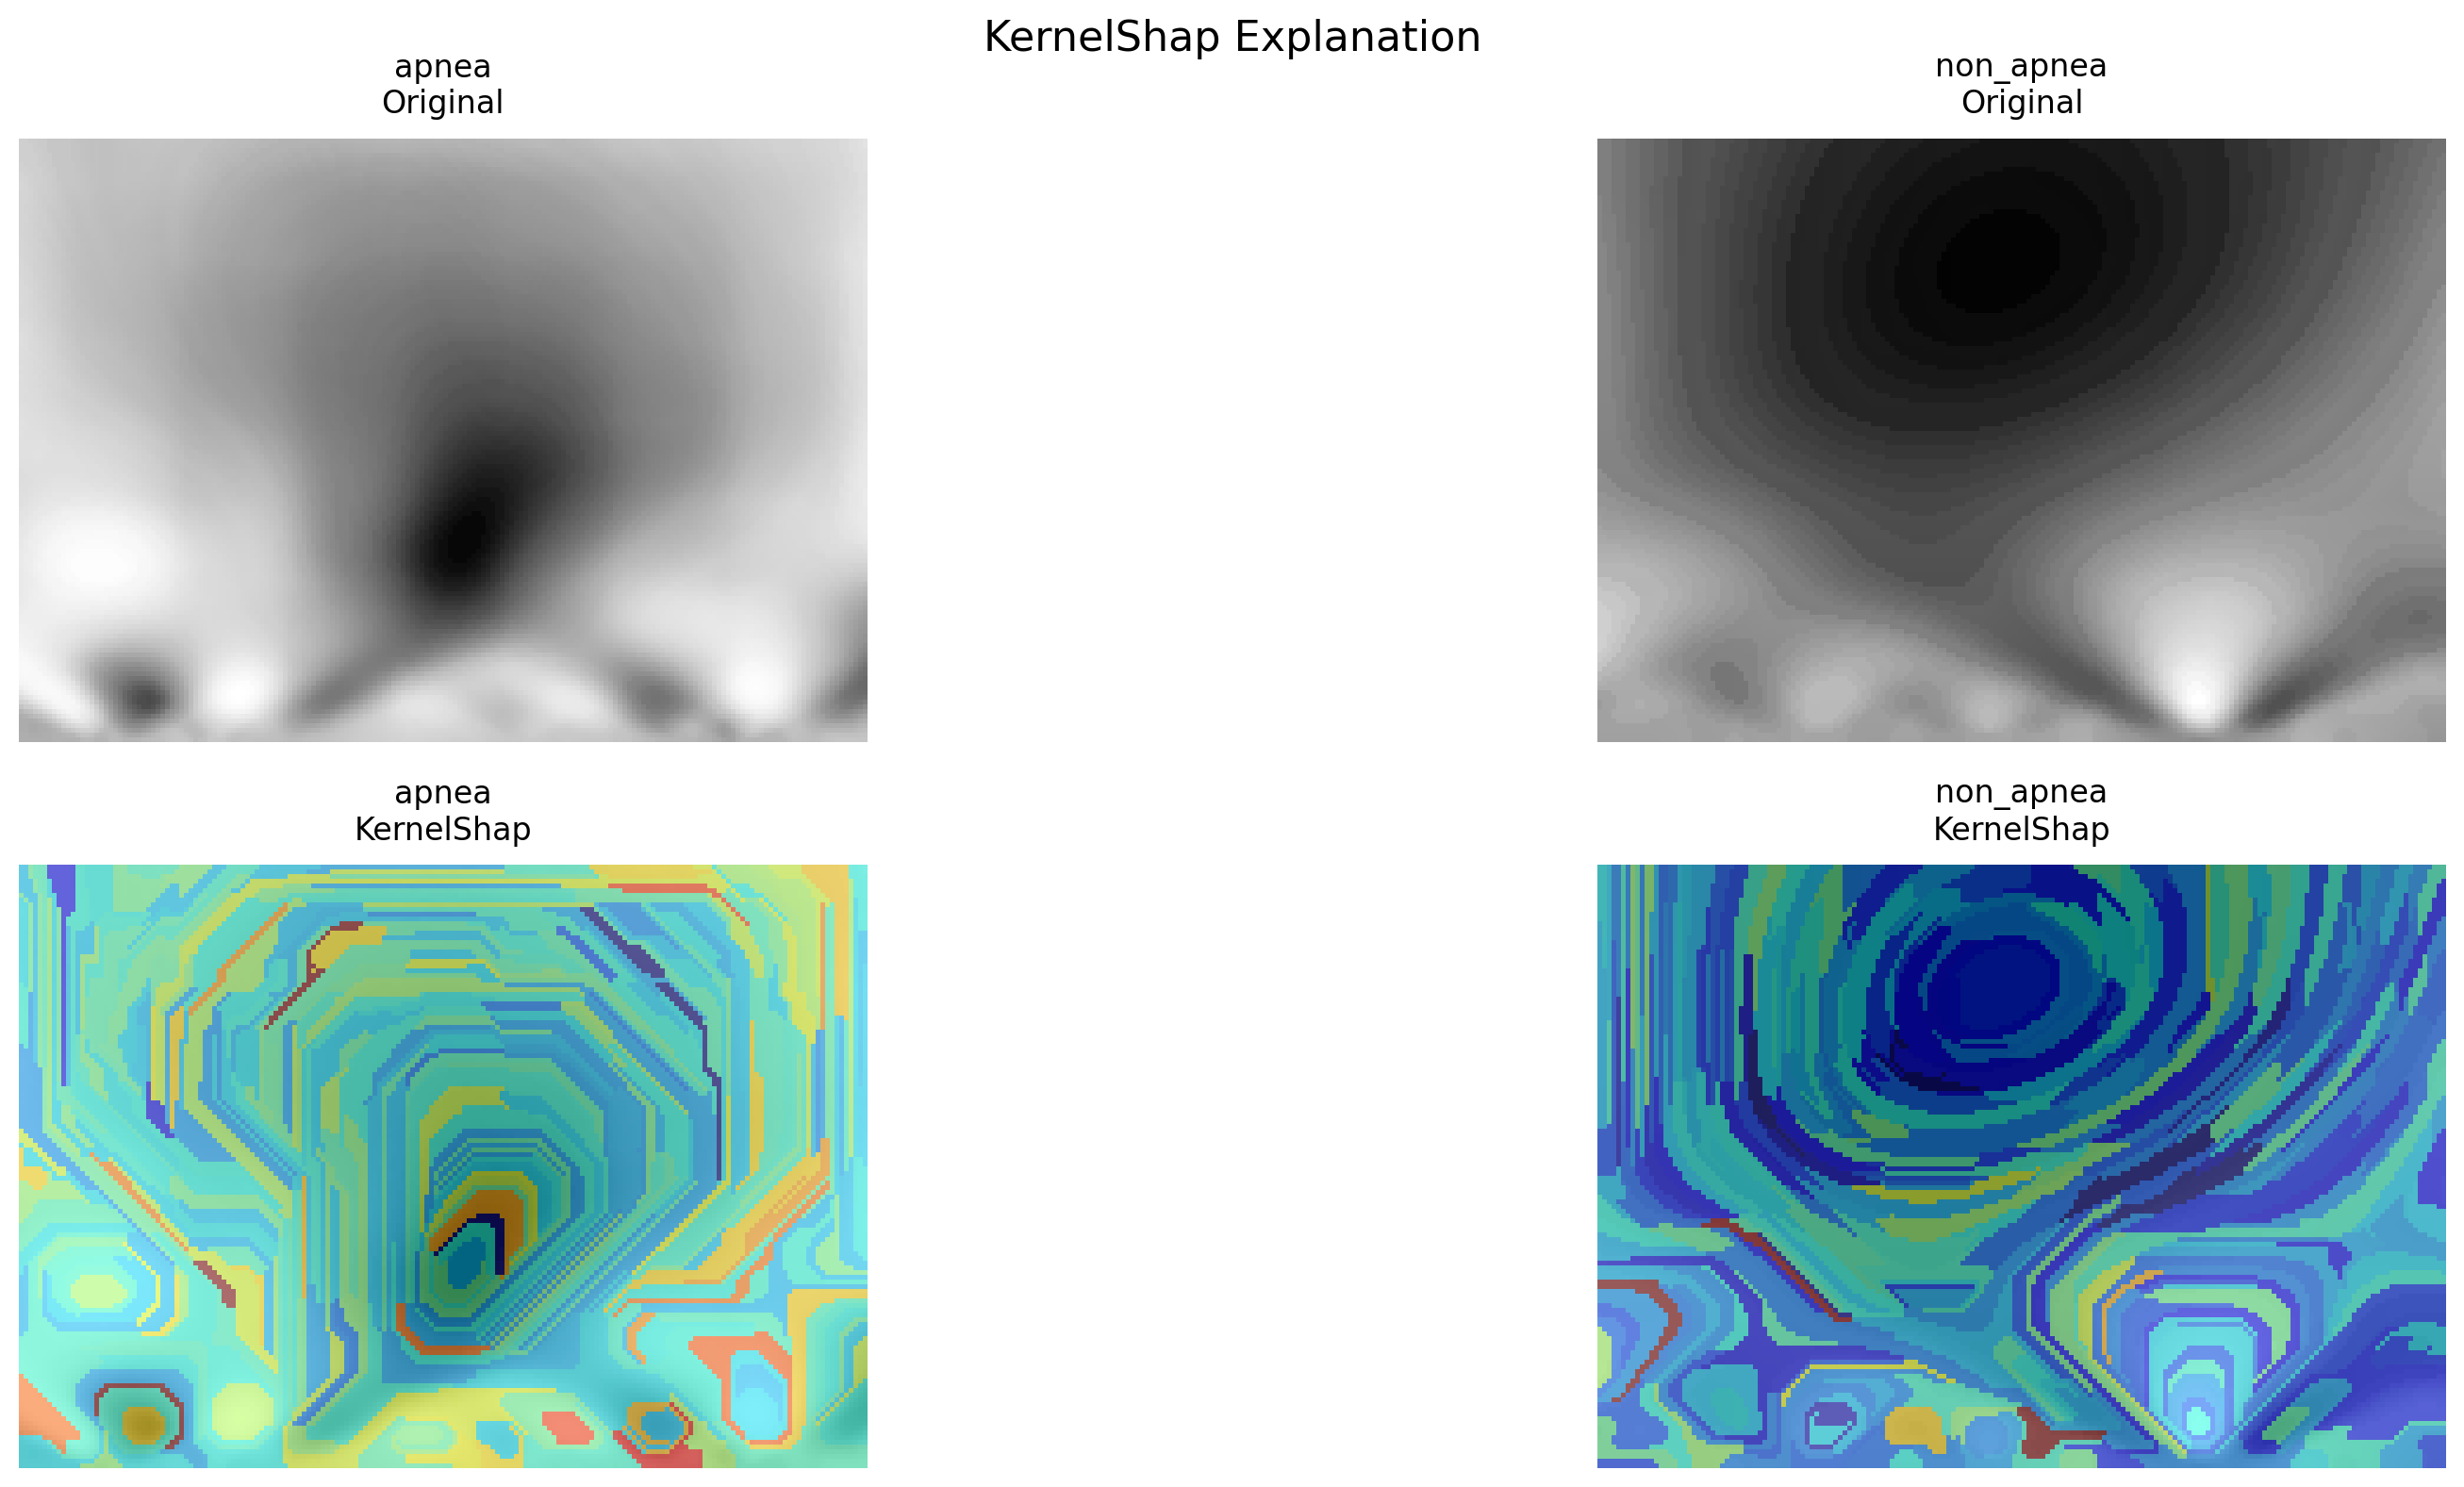

In [31]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients,
                                SmoothGrad, VarGrad, SquareGrad, GradCAM,
                                Occlusion, Rise, GuidedBackprop, GradCAMPP,
                                Lime, KernelShap, SobolAttributionMethod)
import random

# Set parameters
img_height = 128
img_width = 180
classes = ['apnea', 'non_apnea']
batch_size = 16

# Create data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Function to get random images from specific classes
def get_random_images_from_classes(base_path, classes, samples_per_class=1):
    images = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(base_path, 'test', class_name)
        all_images = os.listdir(class_path)

        # Randomly select images
        selected_images = random.sample(all_images, samples_per_class)

        for img_name in selected_images:
            img_path = os.path.join(class_path, img_name)
            # Read as grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_width, img_height))  # Note the order: width, height
            img = img / 255.0  # Normalize
            img = np.expand_dims(img, axis=-1)  # Add channel dimension

            # Create one-hot encoded label
            label = np.zeros(len(classes))
            label[class_idx] = 1

            images.append(img)
            labels.append(label)
            print(f"Selected {img_name} from class {class_name}")

    return np.array(images), np.array(labels)

# Get random images
print("Selecting random images...")
X_samples, y_samples = get_random_images_from_classes('Dataset', classes)

# Convert grayscale to 3 channels for visualization
X_display = np.repeat(X_samples, 3, axis=-1)

# Load the model
model = tf.keras.models.load_model('/content/Main_model.keras')

# Define the explainers
explainers = [
    Saliency(model),
    GradientInput(model),
    GuidedBackprop(model),
    IntegratedGradients(model, steps=50, batch_size=batch_size),
    SmoothGrad(model, nb_samples=50, batch_size=batch_size),
    SquareGrad(model, nb_samples=50, batch_size=batch_size),
    VarGrad(model, nb_samples=50, batch_size=batch_size),
    GradCAM(model),
    Occlusion(model, patch_size=10, patch_stride=5, batch_size=batch_size),
    Rise(model, nb_samples=100, batch_size=batch_size),
    SobolAttributionMethod(model, batch_size=batch_size),
    Lime(model, nb_samples=50),
    KernelShap(model, nb_samples=50)
]

def plot_explanations(X_images, y_labels, explanations, method_name, clip_percentile=0.5):
    n_images = len(X_images)
    # Adjust figure size to maintain aspect ratio
    plt.figure(figsize=(20, 8))  # Increased width to accommodate wider images
    plt.suptitle(f'{method_name} Explanation', fontsize=16, y=0.98)

    # Plot original images
    for i in range(n_images):
        plt.subplot(2, n_images, i + 1)
        plt.imshow(X_images[i], cmap='gray')  # Use grayscale colormap for originals
        plt.title(f'{classes[np.argmax(y_labels[i])]}\nOriginal', pad=10)
        plt.axis('off')

    # Plot explanations
    for i, explanation in enumerate(explanations):
        plt.subplot(2, n_images, n_images + i + 1)
        plt.imshow(X_images[i], cmap='gray')

        # Clip and normalize explanation
        if clip_percentile > 0:
            explanation = np.clip(explanation,
                                np.percentile(explanation, clip_percentile),
                                np.percentile(explanation, 100 - clip_percentile))

        plt.imshow(explanation, cmap='jet', alpha=0.5)
        plt.title(f'{classes[np.argmax(y_labels[i])]}\n{method_name}', pad=10)
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'Sleep_Apnea_{method_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# First, show the selected random images
plt.figure(figsize=(15, 5))  # Adjusted for wider images
plt.suptitle('Selected Random Images for Analysis', fontsize=16, y=1.05)
for i in range(len(X_samples)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_display[i], cmap='gray')
    plt.title(f'{classes[np.argmax(y_samples[i])]}', pad=10)
    plt.axis('off')
plt.tight_layout()
plt.savefig('Selected_Random_Images.png', dpi=300, bbox_inches='tight')
plt.show()

# Print predictions for selected images
predictions = model.predict(X_samples, verbose=0)
print("\nPredictions for selected images:")
for i in range(len(X_samples)):
    print(f"Image {i+1} ({classes[np.argmax(y_samples[i])]})")
    print(f"Confidence: {predictions[i][np.argmax(predictions[i])]:.2%}\n")

# Generate and plot explanations for each method
for explainer in explainers:
    method_name = explainer.__class__.__name__
    print(f"\nGenerating {method_name} explanations...")

    try:
        explanations = explainer(X_samples, y_samples)
        plot_explanations(X_display, y_samples, explanations, method_name)

    except Exception as e:
        print(f"Error generating {method_name} explanations: {str(e)}")